In [11]:
import os
import re
import unicodedata
import random
import json
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from pycocomedical import COCOMedical
from utils.utils import prepare_data

# =============================================================================
# 1) Text preprocessing (for reports)
# =============================================================================
def clean_report(text, eos_token):
    text = unicodedata.normalize('NFKC', text or '')
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'([.!?]){2,}', r'\1', text)
    text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
    text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
    text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
    parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
    text = parts[0]
    fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
    cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
    if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
        text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
    text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
    text = text.replace('_x000D_', ' ')
    text = re.sub(r'\s+', ' ', text).strip()
    if text and not text.endswith(eos_token):
        text += ' ' + eos_token
    return text

# =============================================================================
# 2) Transforms
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

full_img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# 3) Dataset
# =============================================================================
class FootPatchesDatasetWithJson(Dataset):
    def __init__(self, cfg, image_transform, patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.use_raw = cfg.DATASET.USE_RAW
        self.use_patches = cfg.DATASET.USE_PATCH
        self.target_classes = cfg.DATASET.TARGET_CLASSES
        self.abnormal_classify = (
            len(self.target_classes) == 2 and
            'abnormal' in self.target_classes and
            'normal' in self.target_classes
        )
        if self.abnormal_classify:
            self.abnormal_mapping = {
                'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'
            }
        else:
            self.abnormal_mapping = None

        self.use_report = cfg.DATASET.REPORT
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(',')
        self.num_classes = len(self.target_classes)
        self.is_binary = (self.num_classes == 2)

        if not self.use_raw and self.use_patches:
            raise AttributeError("Patches cannot be used without raw images.")

        # Load COCO‐style JSON
        coco = COCOMedical()
        coco.load_json(cfg.DATASET.JSON)
        raw_data = {idx: coco.diseases[name].to_dict()
                    for idx, name in enumerate(coco.diseases)}

        if self.is_binary:
            balanced, _, _ = prepare_data(raw_data, self.target_classes, cfg, self.is_binary)
            self.data = balanced
        else:
            self.data = raw_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        file_path = entry['file_path']

        # Label
        lbl_str = entry['class_label'].lower()
        if self.abnormal_mapping:
            lbl_str = self.abnormal_mapping.get(lbl_str, lbl_str)
        label = self.target_classes.index(lbl_str)

        # Load + transform full image
        img = Image.open(file_path).convert('RGB')
        img = self.image_transform(img)

        # Extract & transform patches
        patches = self._extract_patches(entry['keypoint_id'], file_path)
        if patches:
            patch_tensors = [self.patch_transform(Image.fromarray(p)) for p in patches]
            patches_tensor = torch.stack(patch_tensors, 0)
        else:
            patches_tensor = torch.zeros((34, 3, 112, 112), dtype=torch.float32)

        # Text report tokenization
        raw_report = entry.get('diagnosis', '')
        cleaned = clean_report(raw_report, tokenizer.eos_token)
        tok = tokenizer(cleaned, truncation=True, max_length=512, return_tensors='pt')
        input_ids = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        labels = input_ids.clone()

        # Return dict for collate_fn
        return {
            'full_img': img,
            'patches': patches_tensor,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
            'raw_report': raw_report,
            'cleaned_report': cleaned,
            'class': lbl_str
        }

    def _extract_patches(self, keypoints_dict, image_path,
                         crop_size=(200, 300), patch_size=(112, 112)):
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Cannot read {image_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        def extract_side(kp_list):
            patches = []
            if not kp_list:
                return patches
            kps = kp_list[0]['keypoints']
            for i in range(17):
                x, y, s = int(kps[3*i]), int(kps[3*i+1]), kps[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, img.shape[1])
                    y1 = min(y + crop_size[1]//2, img.shape[0])
                    crop = img[y0:y1, x0:x1]
                    if crop.size:
                        try:
                            patches.append(cv2.resize(crop, patch_size))
                        except:
                            pass
            return patches

        left = extract_side(keypoints_dict.get('left', []))
        right = extract_side(keypoints_dict.get('right', []))
        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left = [cv2.flip(p,1) for p in right]
        if not left and not right:
            black = np.zeros((patch_size[1], patch_size[0],3), np.uint8)
            return [black]*34

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0],3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left = pad17(left)
        right = pad17(right)
        return left + right

# =============================================================================
# 4) collate_fn
# =============================================================================
def collate_fn(batch):
    full_imgs = torch.stack([item['full_img'] for item in batch])
    patch_list = [item['patches'] for item in batch]
    max_patches = max(p.shape[0] for p in patch_list)
    padded = []
    for p in patch_list:
        if p.shape[0] < max_patches:
            pad = torch.zeros((max_patches - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        padded.append(p)
    patches_batch = torch.stack(padded, dim=0)

    input_ids      = [item['input_ids'] for item in batch]
    attention_masks= [item['attention_mask'] for item in batch]
    labels         = [item['labels'] for item in batch]
    input_ids      = nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks= nn.utils.rnn.pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels         = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)

    return {
        'full_imgs': full_imgs,
        'patches': patches_batch,
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'labels': labels,
        'raw_reports':     [item['raw_report']     for item in batch],
        'cleaned_reports': [item['cleaned_report'] for item in batch]
    }

# =============================================================================
# 5) Model Definition
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        # Global (Swin)
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)
        # Patch (ResNet50)
        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)
        # Combine
        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)
        # GPT-2 decoder
        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)
        self.decoder.config.eos_token_id = tokenizer.eos_token_id
        self.decoder.config.pad_token_id = tokenizer.eos_token_id

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim>2 else feats

    def forward(self, full_imgs, patches, input_ids, attention_mask, labels=None):
        # global
        g = self.global_encoder(full_imgs)
        g = self.global_proj(g).unsqueeze(1)
        # patches
        B, N, C, H, W = patches.shape
        p = patches.view(B*N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf).view(B, N, 768)
        # combine
        comb = torch.cat([g, pf], dim=1)
        att, _ = self.attn(comb, comb, comb)
        att = self.norm(att)
        # decode
        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=att,
            labels=labels
        )
        return out

# =============================================================================
# 6) Training/Eval Helpers
# =============================================================================
def train_epoch(model, dataloader, optimizer, scaler, device):
    model.train()
    total_loss=0; total_correct=0; total_tokens=0
    for batch in tqdm(dataloader, desc="Train", leave=False):
        imgs = batch['full_imgs'].to(device)
        pats = batch['patches'].to(device)
        in_ids= batch['input_ids'].to(device)
        attm = batch['attention_mask'].to(device)
        labs = batch['labels'].to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(imgs, pats, in_ids, attm, labs)
            loss = outputs.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()
        total_loss += loss.item()
        preds = outputs.logits.argmax(dim=-1)
        mask = labs != -100
        total_correct += ((preds==labs)&mask).sum().item()
        total_tokens  += mask.sum().item()
    return total_loss/len(dataloader), total_correct/total_tokens

def evaluate(model, dataloader, device):
    model.eval()
    total_loss=0; total_correct=0; total_tokens=0
    all_gen, all_gt = [], []
    for batch in tqdm(dataloader, desc="Eval", leave=False):
        imgs = batch['full_imgs'].to(device)
        pats = batch['patches'].to(device)
        in_ids= batch['input_ids'].to(device)
        attm = batch['attention_mask'].to(device)
        labs = batch['labels'].to(device)
        with torch.no_grad():
            out = model(imgs, pats, in_ids, attm, labs)
            total_loss += out.loss.item()
            preds = out.logits.argmax(dim=-1)
            mask  = labs != -100
            total_correct += ((preds==labs)&mask).sum().item()
            total_tokens  += mask.sum().item()
            # generation
            prompt = in_ids[:, :1]
            # re-compute enc feats
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)
            B,N,C,H,W = pats.shape
            p = pats.view(B*N, C, H, W)
            pf = (model.patch_encoder.forward_features(p)
                  if hasattr(model.patch_encoder, 'forward_features')
                  else model.patch_encoder(p))
            pf = model._pool(pf)
            pf = model.patch_proj(pf).view(B, N, 768)
            comb = torch.cat([g, pf], dim=1)
            att, _ = model.attn(comb, comb, comb)
            att = model.norm(att)
            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=att,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                early_stopping=True,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g, skip_special_tokens=True) for g in gen_ids]
            gt_txt  = [tokenizer.decode(ids, skip_special_tokens=True) for ids in batch['input_ids']]
            all_gen.extend(gen_txt); all_gt.extend(gt_txt)
    return total_loss/len(dataloader), total_correct/total_tokens, all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    emb1 = model.encode(gen, convert_to_tensor=True)
    emb2 = model.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(emb1, emb2).mean().item()

def compute_tfidf_similarity(gen, gt):
    vec = TfidfVectorizer().fit(gen+gt)
    tg = vec.transform(gen)
    gg = vec.transform(gt)
    sims = [cosine_similarity(tg[i], gg[i])[0][0] for i in range(len(gen))]
    return np.mean(sims)

def plot_metrics(train_losses, val_losses, accs, sems, tfids):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,8))
    plt.subplot(2,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(2,2,2)
    plt.plot(epochs, accs, label="Val Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
    plt.subplot(2,2,3)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Similarity"); plt.legend()
    plt.subplot(2,2,4)
    plt.plot(epochs, tfids, label="TF-IDF Sim")
    plt.xlabel("Epoch"); plt.ylabel("Similarity"); plt.legend()
    plt.tight_layout(); plt.show()

# =============================================================================
# 7) Setup & Run
# =============================================================================
# Config inline
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON        = 'final_samples_both_only_fixed.json'
cfg.DATASET.USE_RAW     = True
cfg.DATASET.USE_PATCH   = True
cfg.DATASET.REPORT      = True
cfg.DATASET.TARGET_CLASSES = ['ra','oa','gout','normal']

# Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset & Loaders
dataset = FootPatchesDatasetWithJson(cfg, full_img_transform, patch_transform)
# class distribution
class_counts = {}
for entry in dataset.data.values():
    lbl = entry['class_label'].lower()
    if dataset.abnormal_mapping:
        lbl = dataset.abnormal_mapping.get(lbl,lbl)
    class_counts[lbl] = class_counts.get(lbl,0) + 1
print("Class distribution:", class_counts)
print("Total samples:", len(dataset))

n = len(dataset)
n_train = int(0.8*n); n_val = int(0.1*n); n_test = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

# Model + optimizer + scheduler + scaler
model = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.cuda.amp.GradScaler()

# Training loop
num_epochs = 1
train_losses, val_losses, accuracies, semantic_sims, tfidf_sims = [], [], [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    t_loss, t_acc = train_epoch(model, train_loader, optimizer, scaler, device)
    v_loss, v_acc, gen_txts, gt_txts = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txts, gt_txts)
    tfid = compute_tfidf_similarity(gen_txts, gt_txts)
    train_losses.append(t_loss)
    val_losses.append(v_loss)
    accuracies.append(v_acc)
    semantic_sims.append(sem)
    tfidf_sims.append(tfid)
    print(f"  Train Loss: {t_loss:.4f} | Train Acc: {t_acc:.4f}")
    print(f"  Val   Loss: {v_loss:.4f} | Val   Acc: {v_acc:.4f}")
    print(f"  Sem Sim: {sem:.4f} | TF-IDF Sim: {tfid:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, accuracies, semantic_sims, tfidf_sims)

# Test evaluation
test_loss, test_acc, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)
test_tfidf = compute_tfidf_similarity(test_gen, test_gt)
print("\n--- Test Evaluation ---")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
print(f"Test Sem Sim: {test_sem:.4f} | Test TF-IDF Sim: {test_tfidf:.4f}")

# Examples from test set
print("\n--- Examples from the Test Set ---")
for idx in range(len(test_ds)):
    ex = test_ds[idx]
    raw = ex['raw_report']
    clean = ex['cleaned_report']
    full_img = ex['full_img'].unsqueeze(0).to(device)
    patches  = ex['patches'].unsqueeze(0).to(device)
    prompt   = ex['input_ids'][:1].unsqueeze(0).to(device)

    # recompute encoder features
    g = model.global_encoder(full_img)
    g = model.global_proj(g).unsqueeze(1)
    B,N,C,H,W = patches.shape
    p = patches.view(B*N, C, H, W)
    pf = (model.patch_encoder.forward_features(p)
          if hasattr(model.patch_encoder, 'forward_features')
          else model.patch_encoder(p))
    pf = model._pool(pf)
    pf = model.patch_proj(pf).view(B, N, 768)
    comb = torch.cat([g, pf], dim=1)
    att, _ = model.attn(comb, comb, comb)
    att = model.norm(att)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=att,
        attention_mask=torch.ones_like(prompt),
        max_length=120,
        early_stopping=True,
        do_sample=True,
        top_k=40,
        top_p=0.95,
        temperature=0.5,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen_report = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\nExample {idx}")
    print("Raw Report:    ", raw)
    print("Cleaned Report:", clean)
    print("Generated:     ", gen_report)


ModuleNotFoundError: No module named 'pycocomedical'

In [14]:
import os
import re
import unicodedata
import json
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from utils.utils import prepare_data

# =============================================================================
# 1) Transforms
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# 2) Dataset
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        """
        Final Samples JSON 기반 Lazy Loading Dataset
        """
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.use_raw = cfg.DATASET.USE_RAW
        self.use_patches = cfg.DATASET.USE_PATCH
        self.target_classes = cfg.DATASET.TARGET_CLASSES
        self.use_report = cfg.DATASET.REPORT

        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        if not isinstance(self.target_classes, list):
            raise TypeError(f"Expected list for target_classes, but got {type(self.target_classes)}")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes

        if self.abnormal_classify:
            self.abnormal_mapping = {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
        else:
            self.abnormal_mapping = None

        # JSON 데이터 로드
        with open(cfg.DATASET.JSON, 'r') as f:
            json_data = json.load(f)

        # JSON -> 내부 데이터 포맷 변환
        self.data = {}
        for idx, item in enumerate(json_data):
            class_label = item.get('class', 'unknown')
            if self.abnormal_mapping:
                class_label = self.abnormal_mapping.get(class_label.lower(), class_label.lower())

            self.data[idx] = {
                "file_path": item["merged_image_path"],
                "left_right_file_path": item["file_paths"],
                "class_label": class_label,
                "diagnosis": item.get("diagnosis", ""),
                "keypoints": item.get("keypoints", {})
            }

        # prepare_data 적용
        if self.is_binary:
            balanced_data, _, _ = prepare_data(self.data, self.target_classes, cfg, self.is_binary)
            self.data = balanced_data

        # for report cleaning
        self.eos_token = tokenizer.eos_token

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]

        # 전체 이미지 (merged)
        img = Image.open(entry['file_path']).convert("RGB")
        img = self.image_transform(img)

        # patches 생성
        patches = self.generate_patches_from_file_paths(
            entry['left_right_file_path'],
            entry['keypoints']
        )
        patch_tensors = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patch_tensor = torch.stack(patch_tensors, dim=0) if patch_tensors else torch.zeros(34, 3, 112, 112)

        # 레이블 변환
        lbl_str = entry['class_label'].lower()
        if self.abnormal_mapping:
            lbl_str = self.abnormal_mapping.get(lbl_str, lbl_str)
        label = self.target_classes.index(lbl_str)
        label = (torch.tensor(label, dtype=torch.float32).unsqueeze(0)
                 if self.is_binary else torch.tensor(label, dtype=torch.long))

        # 리포트 처리
        report = self._clean_report(entry.get("diagnosis", ""))

        # Return dict to match collate_fn
        out = {
            'full_img': img,
            'patches': patch_tensor,
            'labels': label,
            'raw_report': entry.get("diagnosis", ""),
            'cleaned_report': report
        }
        # tokenize report
        tok = tokenizer(report, truncation=True, max_length=512, return_tensors='pt')
        out['input_ids']      = tok['input_ids'].squeeze(0)
        out['attention_mask'] = tok['attention_mask'].squeeze(0)

        return out

    def generate_patches_from_file_paths(self, file_paths, keypoints_dict,
                                         crop_size=(200, 300), patch_size=(112, 112)):
        def extract(image, kp_side):
            patches = []
            kps = kp_side[0]['keypoints']
            for i in range(17):
                x, y, score = int(kps[3*i]), int(kps[3*i+1]), kps[3*i+2]
                if score > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, image.shape[1])
                    y1 = min(y + crop_size[1]//2, image.shape[0])
                    crop = image[y0:y1, x0:x1]
                    if crop.size:
                        try:
                            patches.append(cv2.resize(crop, patch_size))
                        except:
                            pass
            return patches

        def pad_to_17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), dtype=np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left_patches, right_patches = [], []

        if len(file_paths) == 1:
            img_arr = cv2.imread(file_paths[0])
            if img_arr is None:
                raise FileNotFoundError(f"Cannot read {file_paths[0]}")
            img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if keypoints_dict.get('left'):  left_patches  = extract(img_arr, keypoints_dict['left'])
            if keypoints_dict.get('right'): right_patches = extract(img_arr, keypoints_dict['right'])
        else:
            # two separate images
            for side, path in zip(['left','right'], file_paths):
                arr = cv2.imread(path)
                if arr is None:
                    raise FileNotFoundError(f"Cannot read {path}")
                arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
                if keypoints_dict.get(side):
                    if side=='left':
                        left_patches  = extract(arr, keypoints_dict['left'])
                    else:
                        right_patches = extract(arr, keypoints_dict['right'])

        # fallback mirroring
        if left_patches and not right_patches:
            right_patches = [cv2.flip(p,1) for p in left_patches]
        if right_patches and not left_patches:
            left_patches = [cv2.flip(p,1) for p in right_patches]
        if not left_patches and not right_patches:
            return [np.zeros((patch_size[1],patch_size[0],3),np.uint8)] * 34

        left_patches  = pad_to_17(left_patches)
        right_patches = pad_to_17(right_patches)
        return left_patches + right_patches

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text,
                          flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '',
                      text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        if text and not text.endswith(self.eos_token):
            text += ' ' + self.eos_token
        return text

# =============================================================================
# 3) collate_fn
# =============================================================================
def collate_fn(batch):
    full_imgs    = torch.stack([item['full_img']       for item in batch])
    patch_list   = [item['patches']                   for item in batch]
    max_patches  = max(p.shape[0] for p in patch_list)
    padded       = []
    for p in patch_list:
        if p.shape[0] < max_patches:
            pad = torch.zeros((max_patches - p.shape[0], *p.shape[1:]))
            p   = torch.cat([p, pad], dim=0)
        padded.append(p)
    patches_batch = torch.stack(padded, dim=0)

    input_ids      = [item['input_ids']      for item in batch]
    attention_masks= [item['attention_mask'] for item in batch]
    labels         = [item['labels']         for item in batch]

    input_ids      = nn.utils.rnn.pad_sequence(input_ids,      batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks= nn.utils.rnn.pad_sequence(attention_masks,batch_first=True, padding_value=0)
    labels         = nn.utils.rnn.pad_sequence(labels,         batch_first=True, padding_value=-100)

    return {
        'full_imgs':      full_imgs,
        'patches':        patches_batch,
        'input_ids':      input_ids,
        'attention_mask': attention_masks,
        'labels':         labels,
        'raw_reports':    [item['raw_report']     for item in batch],
        'cleaned_reports':[item['cleaned_report'] for item in batch]
    }

# =============================================================================
# 4) Model Definition
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        # Global (Swin)
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)
        # Patch (ResNet50)
        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)
        # Combine
        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)
        # GPT-2 decoder
        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)
        self.decoder.config.eos_token_id = tokenizer.eos_token_id
        self.decoder.config.pad_token_id = tokenizer.eos_token_id

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim>2 else feats

    def forward(self, full_imgs, patches, input_ids, attention_mask, labels=None):
        # global
        g = self.global_encoder(full_imgs)
        g = self.global_proj(g).unsqueeze(1)
        # patches
        B, N, C, H, W = patches.shape
        p = patches.view(B*N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf).view(B, N, 768)
        # combine
        comb, _ = self.attn(torch.cat([g, pf], dim=1),
                            torch.cat([g, pf], dim=1),
                            torch.cat([g, pf], dim=1))
        comb = self.norm(comb)
        # decode
        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=labels
        )
        return out

# =============================================================================
# 5) Training/Eval Helpers
# =============================================================================
def train_epoch(model, dataloader, optimizer, scaler, device):
    model.train()
    total_loss=0; total_correct=0; total_tokens=0
    for batch in tqdm(dataloader, desc="Train", leave=False):
        imgs = batch['full_imgs'].to(device)
        pats = batch['patches'].to(device)
        ids  = batch['input_ids'].to(device)
        msk  = batch['attention_mask'].to(device)
        labs = batch['labels'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast(device_type='cuda'):
            out = model(imgs, pats, ids, msk, labs)
            loss= out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()

        total_loss   += loss.item()
        preds        = out.logits.argmax(dim=-1)
        mask_valid   = labs != -100
        total_correct+= ((preds==labs)&mask_valid).sum().item()
        total_tokens += mask_valid.sum().item()

    return total_loss/len(dataloader), total_correct/total_tokens

def evaluate(model, dataloader, device):
    model.eval()
    total_loss=0; total_correct=0; total_tokens=0
    all_gen, all_gt = [], []
    for batch in tqdm(dataloader, desc="Eval", leave=False):
        imgs = batch['full_imgs'].to(device)
        pats = batch['patches'].to(device)
        ids  = batch['input_ids'].to(device)
        msk  = batch['attention_mask'].to(device)
        labs = batch['labels'].to(device)
        with torch.no_grad():
            out = model(imgs, pats, ids, msk, labs)
            total_loss   += out.loss.item()
            preds         = out.logits.argmax(dim=-1)
            mask_valid    = labs != -100
            total_correct += ((preds==labs)&mask_valid).sum().item()
            total_tokens  += mask_valid.sum().item()

            # generation
            prompt = ids[:, :1]
            # recompute encoder features
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)
            B,N,C,H,W = pats.shape
            p = pats.view(B*N, C, H, W)
            pf= (model.patch_encoder.forward_features(p)
                 if hasattr(model.patch_encoder,'forward_features')
                 else model.patch_encoder(p))
            pf= model._pool(pf).view(B,N,768)
            comb,_ = model.attn(torch.cat([g,pf],dim=1),torch.cat([g,pf],dim=1),torch.cat([g,pf],dim=1))
            comb= model.norm(comb)

            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=comb,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                early_stopping=True,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g, skip_special_tokens=True) for g in gen_ids]
            gt_txt  = [tokenizer.decode(ids_, skip_special_tokens=True) for ids_ in batch['input_ids']]
            all_gen.extend(gen_txt); all_gt.extend(gt_txt)

    return total_loss/len(dataloader), total_correct/total_tokens, all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    emb1  = model.encode(gen, convert_to_tensor=True)
    emb2  = model.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(emb1, emb2).mean().item()

def compute_tfidf_similarity(gen, gt):
    vec = TfidfVectorizer().fit(gen+gt)
    tg  = vec.transform(gen)
    gg  = vec.transform(gt)
    sims= [cosine_similarity(tg[i], gg[i])[0][0] for i in range(len(gen))]
    return np.mean(sims)

def plot_metrics(train_losses, val_losses, accs, sems, tfids):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,8))
    plt.subplot(2,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(2,2,2)
    plt.plot(epochs, accs, label="Val Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
    plt.subplot(2,2,3)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Similarity"); plt.legend()
    plt.subplot(2,2,4)
    plt.plot(epochs, tfids, label="TF-IDF Sim")
    plt.xlabel("Epoch"); plt.ylabel("Similarity"); plt.legend()
    plt.tight_layout(); plt.show()

# =============================================================================
# 6) Setup & Run
# =============================================================================
# Config inline
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON             = 'final_samples_both_only_fixed.json'
cfg.DATASET.USE_RAW          = True
cfg.DATASET.USE_PATCH        = True
cfg.DATASET.REPORT           = True
cfg.DATASET.TARGET_CLASSES   = ['ra','oa','gout','normal']

# Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset & Loaders
dataset = FinalSamplesDataset(cfg)
# class distribution
class_counts = {}
for entry in dataset.data.values():
    lbl = entry['class_label'].lower()
    if dataset.abnormal_classify:
        lbl = dataset.abnormal_mapping.get(lbl,lbl)
    class_counts[lbl] = class_counts.get(lbl,0) + 1
print("Class distribution:", class_counts)
print("Total samples:", len(dataset))

n       = len(dataset)
n_train = int(0.8*n); n_val = int(0.1*n); n_test = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

# Model + optimizer + scheduler + scaler
model     = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.cuda.amp.GradScaler()

# Training loop
num_epochs = 1
train_losses, val_losses, accuracies, semantic_sims, tfidf_sims = [], [], [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    t_loss, t_acc           = train_epoch(model, train_loader, optimizer, scaler, device)
    v_loss, v_acc, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem                     = compute_semantic_similarity(gen_txt, gt_txt)
    tfid                    = compute_tfidf_similarity(gen_txt, gt_txt)
    train_losses.append(t_loss)
    val_losses.append(v_loss)
    accuracies.append(v_acc)
    semantic_sims.append(sem)
    tfidf_sims.append(tfid)
    print(f"  Train Loss: {t_loss:.4f} | Train Acc: {t_acc:.4f}")
    print(f"  Val   Loss: {v_loss:.4f} | Val   Acc: {v_acc:.4f}")
    print(f"  Sem Sim: {sem:.4f} | TF-IDF Sim: {tfid:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, accuracies, semantic_sims, tfidf_sims)

# Test evaluation
test_loss, test_acc, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)
test_tfidf = compute_tfidf_similarity(test_gen, test_gt)
print("\n--- Test Evaluation ---")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
print(f"Test Sem Sim: {test_sem:.4f} | Test TF-IDF Sim: {test_tfidf:.4f}")

# Examples from test set
print("\n--- Examples from the Test Set ---")
for idx in range(len(test_ds)):
    ex = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)
    prompt= ex['input_ids'][:1].unsqueeze(0).to(device)

    # encode
    g = model.global_encoder(fi)
    g = model.global_proj(g).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p = pa.view(B*N,C,H,W)
    pf= model.patch_encoder.forward_features(p) if hasattr(model.patch_encoder,'forward_features') else model.patch_encoder(p)
    pf= model._pool(pf).view(B,N,768)
    comb,_ = model.attn(torch.cat([g,pf],dim=1),torch.cat([g,pf],dim=1),torch.cat([g,pf],dim=1))
    comb= model.norm(comb)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        attention_mask=torch.ones_like(prompt),
        max_length=120,
        early_stopping=True,
        do_sample=True,
        top_k=40,
        top_p=0.95,
        temperature=0.5,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen_report = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\nExample {idx}")
    print("Raw Report:    ", raw)
    print("Cleaned Report:", clean)
    print("Generated:     ", gen_report)


ModuleNotFoundError: No module named 'utils.utils'

In [3]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# =============================================================================
# 0) Inlined utility functions
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal   = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal':   data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal':   class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts

    min_count = min(combined_counts.values())
    balanced, final_counts = [], {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes)==2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    if is_binary and len(target_classes)!=2:
        raise ValueError("Binary classification requires exactly 2 target classes.")
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts

    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        logging.info("Applied augmentation: dataset doubled")
    return balanced, class_counts, final_counts

# =============================================================================
# 1) Transforms
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# 2) Dataset
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")
        if not isinstance(self.target_classes, list):
            raise TypeError(f"target_classes must be list, got {type(self.target_classes)}")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra':'abnormal','oa':'abnormal','gout':'abnormal','normal':'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw = json.load(f)
        self.data = {}
        for i, item in enumerate(raw):
            cls = item.get('class','unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': item['merged_image_path'],
                'left_right_file_path': item['file_paths'],
                'class_label': cls,
                'diagnosis': item.get('diagnosis',''),
                'keypoints': item.get('keypoints',{})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.eos_token = tokenizer.eos_token

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)

        lbl = e['class_label']
        if self.abnormal_mapping:
            lbl = self.abnormal_mapping.get(lbl, lbl)
        li = self.target_classes.index(lbl)

        # Wrap the label index into a 1-D tensor
        if self.is_binary:
            label = torch.tensor([li], dtype=torch.float32)
        else:
            label = torch.tensor([li], dtype=torch.long)

        raw = e.get('diagnosis','')
        clean = self._clean_report(raw)
        tok = tokenizer(clean, truncation=True, max_length=512, return_tensors='pt')

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'labels':         label,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        try:
                            lst.append(cv2.resize(c, patch_size))
                        except:
                            pass
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            arr = cv2.cvtColor(cv2.imread(paths[0]), cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):
                left = extract(arr, kps_dict['left'])
            if kps_dict.get('right'):
                right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                arr = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
                if kps_dict.get(side):
                    if side == 'left':
                        left = extract(arr, kps_dict['left'])
                    else:
                        right = extract(arr, kps_dict['right'])

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return [np.zeros((patch_size[1], patch_size[0], 3), np.uint8)] * 34

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        if text and not text.endswith(self.eos_token):
            text += ' ' + self.eos_token
        return text

# =============================================================================
# 3) Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts  = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids   = [b['input_ids']      for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids,   batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    labels = torch.stack([b['labels'] for b in batch], dim=0)

    return {
        'full_imgs':      imgs,
        'patches':        patches,
        'input_ids':      ids,
        'attention_mask': masks,
        'labels':         labels,
        'raw_reports':    [b['raw_report']     for b in batch],
        'cleaned_reports':[b['cleaned_report'] for b in batch]
    }

# =============================================================================
# 4) Model Definition
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)
        self.decoder.config.eos_token_id = tokenizer.eos_token_id
        self.decoder.config.pad_token_id = tokenizer.eos_token_id

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, labels=None):
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p = patches.view(B*N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf).view(B, N, 768)

        comb, _ = self.attn(torch.cat([g, pf], dim=1),
                            torch.cat([g, pf], dim=1),
                            torch.cat([g, pf], dim=1))
        comb = self.norm(comb)

        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=labels
        )

# =============================================================================
# 5) Training & Eval Helpers
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_tokens = 0

    for b in tqdm(loader, desc="Train", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)
        lbls = b['labels'].to(device)

        optimizer.zero_grad()
        # Removed unsupported device_type argument
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, lbls)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = out.logits.argmax(dim=-1)
        maskv = lbls != -100
        total_correct += ((preds == lbls) & maskv).sum().item()
        total_tokens  += maskv.sum().item()

    return total_loss / len(loader), total_correct / total_tokens

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    all_gen, all_gt = [], []

    for b in tqdm(loader, desc="Eval", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)
        lbls = b['labels'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, lbls)
            total_loss += out.loss.item()
            preds = out.logits.argmax(dim=-1)
            maskv = lbls != -100
            total_correct += ((preds == lbls) & maskv).sum().item()
            total_tokens  += maskv.sum().item()

            prompt = ids[:, :1]
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)
            B, N, C, H, W = pts.shape
            p = pts.view(B*N, C, H, W)
            pf = (model.patch_encoder.forward_features(p)
                  if hasattr(model.patch_encoder, 'forward_features')
                  else model.patch_encoder(p))
            pf = model._pool(pf).view(B, N, 768)
            comb, _ = model.attn(torch.cat([g, pf], dim=1),
                                 torch.cat([g, pf], dim=1),
                                 torch.cat([g, pf], dim=1))
            comb = model.norm(comb)

            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=comb,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                early_stopping=True,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt  = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in b['input_ids']]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), total_correct / total_tokens, all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def compute_tfidf_similarity(gen, gt):
    vec = TfidfVectorizer().fit(gen + gt)
    tgm = vec.transform(gen)
    gtm = vec.transform(gt)
    sims = [cosine_similarity(tgm[i], gtm[i])[0][0] for i in range(len(gen))]
    return np.mean(sims)

def plot_metrics(train_losses, val_losses, accs, sems, tfids):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(2, 2, 2)
    plt.plot(epochs, accs, label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
    plt.subplot(2, 2, 3)
    plt.plot(epochs, sems, label="Sem Sim")
    plt.xlabel("Epoch"); plt.ylabel("Similarity"); plt.legend()
    plt.subplot(2, 2, 4)
    plt.plot(epochs, tfids, label="TF-IDF Sim")
    plt.xlabel("Epoch"); plt.ylabel("Similarity"); plt.legend()
    plt.tight_layout(); plt.show()

# =============================================================================
# 6) Main: setup & run
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_fixed.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['ra', 'oa', 'gout', 'normal', 'uncertain', 'ref.prev']
cfg.DATASET.BALANCE        = False
cfg.DATASET.AUGMENT        = False

# tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# dataset & loaders
dataset = FinalSamplesDataset(cfg)
counts = defaultdict(int)
for e in dataset.data.values():
    lbl = e['class_label']
    if dataset.abnormal_classify:
        lbl = dataset.abnormal_mapping.get(lbl, lbl)
    counts[lbl] += 1
print("Class distribution:", dict(counts))
print("Total samples:", len(dataset))

n = len(dataset)
n_train = int(0.8 * n); n_val = int(0.1 * n); n_test = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

model     = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.cuda.amp.GradScaler()

num_epochs = 1
train_losses, val_losses, accs, sems, tfids = [], [], [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    t_loss, t_acc                = train_epoch(model, train_loader, optimizer, scaler, device)
    v_loss, v_acc, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem   = compute_semantic_similarity(gen_txt, gt_txt)
    tfid  = compute_tfidf_similarity(gen_txt, gt_txt)

    train_losses.append(t_loss)
    val_losses.append(v_loss)
    accs.append(t_acc)
    sems.append(sem)
    tfids.append(tfid)

    print(f"  Train Loss: {t_loss:.4f} | Train Acc: {t_acc:.4f}")
    print(f"  Val   Loss: {v_loss:.4f} | Val   Acc: {v_acc:.4f}")
    print(f"  Sem Sim: {sem:.4f} | TF-IDF Sim: {tfid:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, accs, sems, tfids)

test_loss, test_acc, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem   = compute_semantic_similarity(test_gen, test_gt)
test_tfidf = compute_tfidf_similarity(test_gen, test_gt)
print("\n--- Test Evaluation ---")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
print(f"Test Sem Sim: {test_sem:.4f} | Test TF-IDF Sim: {test_tfidf:.4f}")

print("\n--- Examples from Test Set ---")
for idx in range(len(test_ds)):
    ex    = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)
    prompt= ex['input_ids'][:1].unsqueeze(0).to(device)

    g = model.global_encoder(fi); g = model.global_proj(g).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B*N, C, H, W)
    pf = (model.patch_encoder.forward_features(p)
          if hasattr(model.patch_encoder, 'forward_features')
          else model.patch_encoder(p))
    pf = model._pool(pf).view(B, N, 768)
    comb, _ = model.attn(torch.cat([g, pf], dim=1),
                         torch.cat([g, pf], dim=1),
                         torch.cat([g, pf], dim=1))
    comb = model.norm(comb)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        attention_mask=torch.ones_like(prompt),
        max_length=120,
        early_stopping=True,
        do_sample=True,
        top_k=40,
        top_p=0.95,
        temperature=0.5,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\nExample {idx}")
    print("Raw Report:    ", raw)
    print("Cleaned Report:", clean)
    print("Generated:     ", gen)


Using device: cuda
Class distribution: {'oa': 573, 'ra': 115, 'uncertain': 620, 'oa, ra': 8, 'normal': 748, 'gout': 267, 'combination of oa, ra': 3, 'ref.prev': 60}
Total samples: 2394


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat


Epoch 1/1


Train:   0%|          | 0/479 [00:00<?, ?it/s]/tmp/ipykernel_775589/2359598459.py:354: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


ValueError: Expected input batch_size (212) to match target batch_size (0).

In [1]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# 0) Inlined utility functions
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal   = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal':   data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal':   class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts

    min_count = min(combined_counts.values())
    balanced, final_counts = [], {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes)==2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    if is_binary and len(target_classes)!=2:
        raise ValueError("Binary classification requires exactly 2 target classes.")
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts

    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        logging.info("Applied augmentation: dataset doubled")
    return balanced, class_counts, final_counts

# =============================================================================
# 1) Transforms
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# 2) Dataset
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")
        if not isinstance(self.target_classes, list):
            raise TypeError(f"target_classes must be list, got {type(self.target_classes)}")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra':'abnormal','oa':'abnormal','gout':'abnormal','normal':'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw = json.load(f)
        self.data = {}
        for i, item in enumerate(raw):
            cls = item.get('class','unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': item['merged_image_path'],
                'left_right_file_path': item['file_paths'],
                'class_label': cls,
                'diagnosis': item.get('diagnosis',''),
                'keypoints': item.get('keypoints',{})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        # will be set after tokenizer exists
        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)

        raw = e.get('diagnosis','')
        clean = self._clean_report(raw)
        tok = tokenizer(clean, truncation=True, max_length=512, return_tensors='pt')

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        """
        Read each path safely. If cv2.imread fails or file missing,
        skip that side. In the end, if no patches extracted, return
        full-black patches.
        """
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        try:
                            lst.append(cv2.resize(c, patch_size))
                        except Exception:
                            pass
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        # Support single merged image or separate left/right
        if len(paths) == 1:
            pth = paths[0]
            if os.path.exists(pth):
                img_arr = cv2.imread(pth)
                if img_arr is not None:
                    arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                    if kps_dict.get('left'):
                        left = extract(arr, kps_dict['left'])
                    if kps_dict.get('right'):
                        right = extract(arr, kps_dict['right'])
                else:
                    logging.warning(f"Unable to read image at {pth}")
            else:
                logging.warning(f"Image path does not exist: {pth}")
        else:
            for side, pth in zip(['left','right'], paths):
                if not os.path.exists(pth):
                    logging.warning(f"Image path missing: {pth}")
                    continue
                img_arr = cv2.imread(pth)
                if img_arr is None:
                    logging.warning(f"cv2.imread failed on {pth}")
                    continue
                arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                if kps_dict.get(side):
                    if side == 'left':
                        left = extract(arr, kps_dict['left'])
                    else:
                        right = extract(arr, kps_dict['right'])

        # Mirror if only one side present
        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]

        # If still empty, return all-black
        if not left and not right:
            return [np.zeros((patch_size[1], patch_size[0], 3), np.uint8)] * 34

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        if text and not text.endswith(self.eos_token):
            text += ' ' + self.eos_token
        return text

# =============================================================================
# 3) Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts  = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids   = [b['input_ids']      for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids,   batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs':      imgs,
        'patches':        patches,
        'input_ids':      ids,
        'attention_mask': masks,
        'raw_reports':    [b['raw_report']     for b in batch],
        'cleaned_reports':[b['cleaned_report'] for b in batch]
    }

# =============================================================================
# 4) Model Definition
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p = patches.view(B*N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf).view(B, N, 768)

        comb, _ = self.attn(torch.cat([g, pf], dim=1),
                            torch.cat([g, pf], dim=1),
                            torch.cat([g, pf], dim=1))
        comb = self.norm(comb)

        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )

# =============================================================================
# 5) Training & Eval Helpers (LM only)
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0

    for b in tqdm(loader, desc="Train", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []

    for b in tqdm(loader, desc="Eval", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            prompt = ids[:, :1]
            B, N, C, H, W = pts.shape
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)
            p = pts.view(B*N, C, H, W)
            pf = (model.patch_encoder.forward_features(p)
                  if hasattr(model.patch_encoder, 'forward_features')
                  else model.patch_encoder(p))
            pf = model._pool(pf).view(B, N, 768)
            comb, _ = model.attn(torch.cat([g, pf], dim=1),
                                 torch.cat([g, pf], dim=1),
                                 torch.cat([g, pf], dim=1))
            comb = model.norm(comb)

            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=comb,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                early_stopping=True,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt  = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def compute_tfidf_similarity(gen, gt):
    vec = TfidfVectorizer().fit(gen + gt)
    tgm = vec.transform(gen)
    gtm = vec.transform(gt)
    sims = [cosine_similarity(tgm[i], gtm[i])[0][0] for i in range(len(gen))]
    return np.mean(sims)

def plot_metrics(train_losses, val_losses, sems, tfids):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 9))

    plt.subplot(3, 1, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Cosine Sim"); plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(epochs, tfids, label="TF-IDF Sim")
    plt.xlabel("Epoch"); plt.ylabel("Cosine Sim"); plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# 6) Main: setup & run
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_fixed.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['ra', 'oa', 'gout', 'normal', 'uncertain', 'ref.prev']
cfg.DATASET.BALANCE        = False
cfg.DATASET.AUGMENT        = False

# tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# dataset & loaders
dataset = FinalSamplesDataset(cfg)
dataset.eos_token = tokenizer.eos_token  # set after tokenizer exists

print("Total samples:", len(dataset))
n = len(dataset)
n_train = int(0.8 * n); n_val = int(0.1 * n); n_test = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

model     = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.cuda.amp.GradScaler()

num_epochs = 1
train_losses, val_losses, sems, tfids = [], [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    t_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    v_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem   = compute_semantic_similarity(gen_txt, gt_txt)
    tfid  = compute_tfidf_similarity(gen_txt, gt_txt)

    train_losses.append(t_loss)
    val_losses.append(v_loss)
    sems.append(sem)
    tfids.append(tfid)

    print(f"  Train Loss : {t_loss:.4f}")
    print(f"  Val   Loss : {v_loss:.4f}")
    print(f"  Sem Sim    : {sem:.4f}")
    print(f"  TF-IDF Sim : {tfid:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems, tfids)

# Final test
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem   = compute_semantic_similarity(test_gen, test_gt)
test_tfidf = compute_tfidf_similarity(test_gen, test_gt)
print("\n--- Test Evaluation ---")
print(f"Test Loss   : {test_loss:.4f}")
print(f"Test Sem Sim: {test_sem:.4f}")
print(f"Test TF-IDF : {test_tfidf:.4f}")

print("\n--- Examples from Test Set ---")
for idx in range(len(test_ds)):
    ex    = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)
    prompt= ex['input_ids'][:1].unsqueeze(0).to(device)

    g = model.global_encoder(fi); g = model.global_proj(g).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B*N, C, H, W)
    pf = (model.patch_encoder.forward_features(p)
          if hasattr(model.patch_encoder, 'forward_features')
          else model.patch_encoder(p))
    pf = model._pool(pf).view(B, N, 768)
    comb, _ = model.attn(torch.cat([g, pf], dim=1),
                         torch.cat([g, pf], dim=1),
                         torch.cat([g, pf], dim=1))
    comb = model.norm(comb)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        attention_mask=torch.ones_like(prompt),
        max_length=120,
        early_stopping=True,
        do_sample=True,
        top_k=40,
        top_p=0.95,
        temperature=0.5,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\nExample {idx}")
    print("Raw Report:    ", raw)
    print("Cleaned Report:", clean)
    print("Generated:     ", gen)


2025-05-03 22:09:16.375706: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-03 22:09:16.383786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746335356.392266  777981 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746335356.394808  777981 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746335356.402090  777981 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using device: cuda
Total samples: 2394


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten


Epoch 1/1


Train:   0%|          | 0/479 [00:00<?, ?it/s]/tmp/ipykernel_777981/2116502503.py:360: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Train:  99%|█████████▉| 475/479 [02:10<00:01,  3.81it/s]WARNING:root:cv2.imread failed on .


RuntimeError: shape '[4, 34, 768]' is invalid for input of size 278528

2025-05-04 22:17:48.831668: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 22:17:48.986096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746422269.042482   12685 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746422269.059398   12685 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746422269.188757   12685 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using device: cuda
Total samples: 2394


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten


Epoch 1/1


Train:   0%|          | 0/479 [00:00<?, ?it/s]/tmp/ipykernel_12685/2132815650.py:340: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Eval:   0%|          | 0/60 [00:00<?, ?it/s]            /home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Eval:  90%|█████████ | 54/60 [00:16<00:01,  3.68it/s]WARNING:root:cv2 failed to read .
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss : 1.2990
  Val   Loss : 0.7645
  Sem Sim    : 0.5852
  TF-IDF Sim : 0.4422


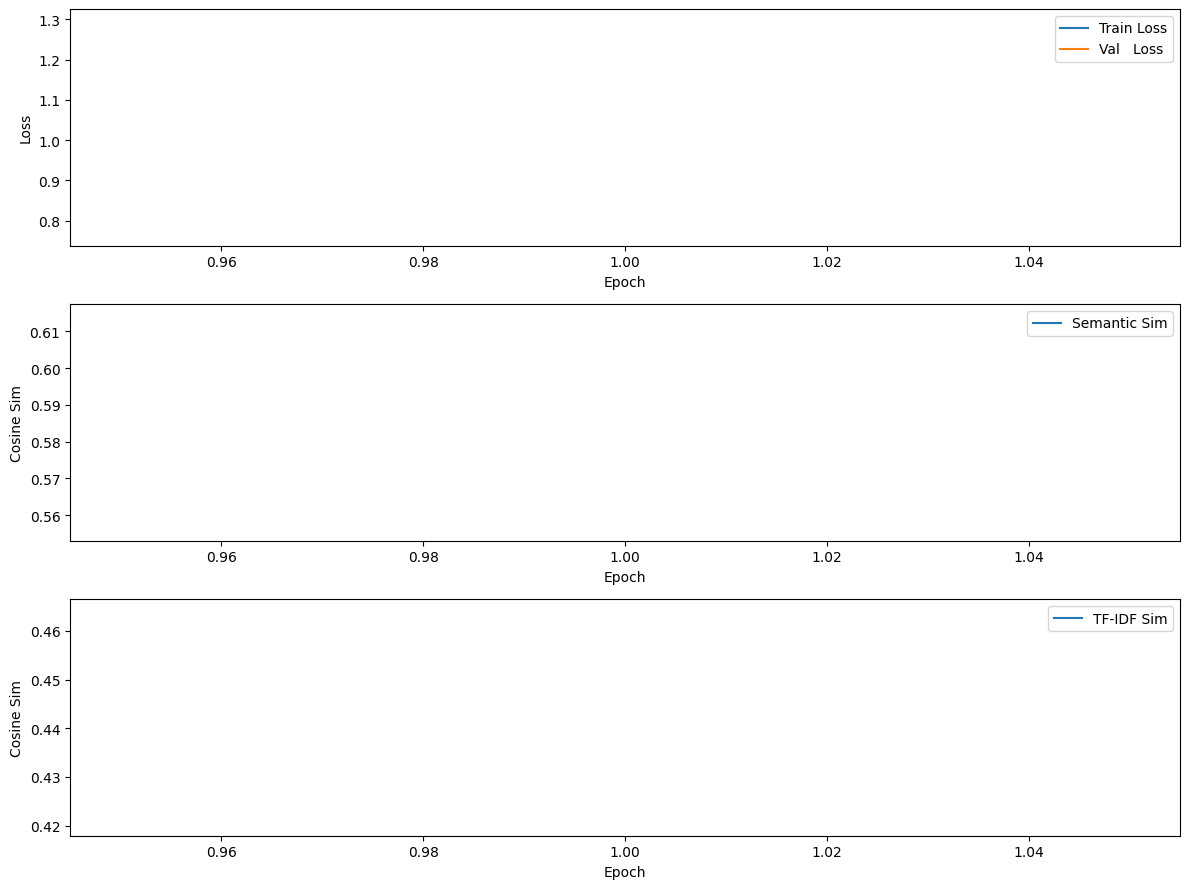

Eval:  75%|███████▌  | 45/60 [00:12<00:04,  3.41it/s]WARNING:root:cv2 failed to read .
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


--- Test Evaluation ---
Test Loss   : 0.7398
Test Sem Sim: 0.5657
Test TF-IDF : 0.4324

--- Examples from Test Set ---

Example 0
Raw Report:     [ Finding ]_x000D_
_x000D_
[ Diagnosis ]_x000D_
1. Mild soft tissue swelling in left foot dorsum._x000D_
2. Enthesophyte in left posterior calcaneal tuberosity._x000D_
3. Small calcification in inferior aspect of left calcaneus._x000D_
[ Recommend ]_x000D_

Cleaned Report: 1. Mild soft tissue swelling in left foot dorsum. 2. Enthesophyte in left posterior calcaneal tuberosity. 3. Small calcification in inferior aspect of left calcaneus. <|endoftext|>
Generated:      1. Hallux valgus, both 

Example 1
Raw Report:     [ Finding ]_x000D_
No bony abnormality._x000D_
[ Diagnosis ]_x000D_
No bony abnormality._x000D_
[ Recommend ]_x000D_

Cleaned Report: No bony abnormality. No bony abnormality. <|endoftext|>
Generated:      No significant interval change 

Example 2
Raw Report:     [FINDING       ]_x000D_ulnar positive variance, both.
diffuse oste


Example 16
Raw Report:     [FINDING       ]_x000D_hallux valgus, both 
mild degenerative change 
diffuse osteopenia _x000D__x000D_[CONCLUSION    ]_x000D_hallux valgus, both 
mild degenerative change 
diffuse osteopenia _x000D__x000D_[RECOMMENDATION]_x000D_-
Cleaned Report: hallux valgus, both mild degenerative change diffuse osteopenia <|endoftext|>
Generated:      hallux valgus, both. 

Example 17
Raw Report:     [FINDING       ]_x000D_hallux valgus, both 
degenerative change _x000D__x000D_[CONCLUSION    ]_x000D_hallux valgus, both 
degenerative change _x000D__x000D_[RECOMMENDATION]_x000D_-
Cleaned Report: hallux valgus, both degenerative change <|endoftext|>
Generated:      hallux valgus, both. 

Example 18
Raw Report:     [ Finding ]_x000D_
포함된 bone에 이상소견은 보이지 않음._x000D_
보이는 한도내에 soft tissue에 이상소견 보이지 않음._x000D_
[ Diagnosis ]_x000D_
No bony abnormality_x000D_
[ Recommend ]_x000D_

Cleaned Report: bone . soft tissue . No bony abnormality <|endoftext|>
Generated:      bone bony lesio


Example 28
Raw Report:     [ Finding ]_x000D_
degenerative change of both feet._x000D_
[ Conclusion ]_x000D_
degenerative change of both feet._x000D_
[ Recommend ]_x000D_

Cleaned Report: degenerative change of both feet. <|endoftext|>
Generated:      degenerative change. 

Example 29
Raw Report:     [FINDING       ]_x000D_mild degenerative change._x000D__x000D_[CONCLUSION    ]_x000D_mild degenerative change._x000D__x000D_[RECOMMENDATION]_x000D_-
Cleaned Report: mild degenerative change. <|endoftext|>
Generated:      mild degenerative change. 

Example 30
Raw Report:     [ Finding ]_x000D_
No bony abnormality_x000D_
_x000D_
[ Diagnosis ]_x000D_
No bony abnormality_x000D_
[ Recommend ]_x000D_

Cleaned Report: No bony abnormality No bony abnormality <|endoftext|>
Generated:      No significant interval change 

Example 31
Raw Report:     [ Finding ]_x000D_
_x000D_
[ Diagnosis ]_x000D_
no significant bony lesion on radiographs._x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report: no sign


Example 108
Raw Report:     [ Finding ]_x000D_
OA in left 1st MTP._x000D_
[ Diagnosis ]_x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report: OA in left 1st MTP. <|endoftext|>
Generated:      OA. soft tissue swelling, both feet and ankles with erosion in medial portion of right foot base area on radiographs 

Example 109
Raw Report:     [ Finding ]_x000D_
no significant interval change since last study._x000D_
[ Conclusion ]_x000D_
no significant interval change since last study._x000D_
[ Recommend ]_x000D_

Cleaned Report: no significant interval change since last study. <|endoftext|>
Generated:      no bony lesion. 

Example 110
Raw Report:     [ Finding ]_x000D_
both 1st MTP joint, bony erosion, suspicious._x000D_
_x000D_
[ Diagnosis ]_x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report: both 1st MTP joint, bony erosion, suspicious. <|endoftext|>
Generated:      both bony lesion. 

Example 111
Raw Report:     [ Finding ]_x000D_
Rt. accessory navicular bone, type II_x000D_
[ Conclusi


Example 130
Raw Report:     [ Finding ]_x000D_
no significant bony lesion on radiographs._x000D_
_x000D_
[ Conclusion ]_x000D_
no significant bony lesion on radiographs._x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report: no significant bony lesion on radiographs. <|endoftext|>
Generated:      no significant bony lesion on radiographs. 

Example 131
Raw Report:     [ Finding ]_x000D_
degenerative change._x000D_
[ Conclusion ]_x000D_
degenerative change._x000D_
[ Recommend ]_x000D_

Cleaned Report: degenerative change. <|endoftext|>
Generated:      degenerative change. 

Example 132
Raw Report:     [ Finding ]_x000D_
degenerative change._x000D_
os naviculare type III, right foot._x000D_
[ Conclusion ]_x000D_
degenerative change._x000D_
os naviculare type III, right foot._x000D_
[ Recommend ]_x000D_

Cleaned Report: degenerative change. os naviculare type III, right foot. <|endoftext|>
Generated:      degenerative change. 

Example 133
Raw Report:     [ Finding ]_x000D_
both accessory 


Example 145
Raw Report:     [ Finding ]_x000D_
both accessory navicular bone, type II_x000D_
degenerative change, both feet._x000D_
_x000D_
[ Conclusion ]_x000D_
both accessory navicular bone, type II_x000D_
degenerative change, both feet._x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report: both accessory navicular bone, type II degenerative change, both feet. <|endoftext|>
Generated:      both significant bony abnormality 

Example 146
Raw Report:     [ Finding ]_x000D_
no significant bony lesion on radiographs._x000D_
_x000D_
[ Conclusion ]_x000D_
no significant bony lesion on radiographs._x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report: no significant bony lesion on radiographs. <|endoftext|>
Generated:      no significant bony lesion on radiographs. 

Example 147
Raw Report:     [ Finding ]_x000D_
No bony abnormality_x000D_
[ Diagnosis ]_x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report: No bony abnormality <|endoftext|>
Generated:      No significant interval change 

Exam


Example 154
Raw Report:     [ Finding ]_x000D_
Bilateral hallus valgus_x000D_
Diffuse osteopenia_x000D_
Subluxation, Rt. 4th PIP_x000D_
[ Conclusion ]_x000D_
Bilateral hallus valgus_x000D_
Diffuse osteopenia_x000D_
Subluxation, Rt. 4th PIP_x000D_
[ Recommend ]_x000D_

Cleaned Report: Bilateral hallus valgus Diffuse osteopenia Subluxation, Rt. 4th PIP <|endoftext|>
Generated:      Beony lesion. 

Example 155
Raw Report:     [FINDING       ]_x000D_mild degenerative change_x000D__x000D_[CONCLUSION    ]_x000D_mild degenerative change_x000D__x000D_[RECOMMENDATION]_x000D_-
Cleaned Report: mild degenerative change <|endoftext|>
Generated:      mild degenerative change 

Example 156
Raw Report:     [FINDING       ]_x000D_No significant interval change_x000D__x000D_[CONCLUSION    ]_x000D_No significant interval change_x000D__x000D_[RECOMMENDATION]_x000D_-
Cleaned Report: No significant interval change <|endoftext|>
Generated:      No significant interval change 

Example 157
Raw Report:     [ 


Example 181
Raw Report:     [ Finding ]_x000D_
_x000D_
[ Diagnosis ]_x000D_
both accessory navicular bone, type II_x000D_
_x000D_
ulnar negative variance both_x000D_
[ Recommend ]_x000D_

Cleaned Report: both accessory navicular bone, type II ulnar negative variance both <|endoftext|>
Generated:      both bony lesion. 

Example 182
Raw Report:     [ Finding ]_x000D_
No bony abnormality_x000D_
_x000D_
[ Diagnosis ]_x000D_
No bony abnormality_x000D_
[ Recommend ]_x000D_

Cleaned Report: No bony abnormality No bony abnormality <|endoftext|>
Generated:      No significant bony abnormality 

Example 183
Raw Report:     [FINDING       ]_x000D_diffuse osteopenia
degenerative change_x000D__x000D_[CONCLUSION    ]_x000D_diffuse osteopenia
degenerative change_x000D__x000D_[RECOMMENDATION]_x000D_-
Cleaned Report: diffuse osteopenia degenerative change <|endoftext|>
Generated:      diffuse osteopenia degenerative change 

Example 184
Raw Report:     [ Finding ]_x000D_
no significant bony lesion on

In [1]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# 0) Utility functions
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra','oa','gout']
    normal   = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal':   data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal':   class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced, final_counts = [], {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes)==2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    if is_binary and len(target_classes)!=2:
        raise ValueError("Binary classification requires exactly 2 target classes.")
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
        logging.info("Applied augmentation: dataset doubled")
    return balanced, class_counts, final_counts

# =============================================================================
# 1) Transforms
# =============================================================================
imagenet_mean = [0.485,0.456,0.406]
imagenet_std  = [0.229,0.224,0.225]

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112,112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# 2) Dataset
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes,str):
            self.target_classes = self.target_classes.split(",")
        if not isinstance(self.target_classes,list):
            raise TypeError(f"target_classes must be list, got {type(self.target_classes)}")

        self.is_binary = len(self.target_classes)==2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra':'abnormal','oa':'abnormal','gout':'abnormal','normal':'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON,'r') as f:
            raw = json.load(f)
        self.data = {}
        for i,item in enumerate(raw):
            cls = item.get('class','unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls,cls)
            self.data[i] = {
                'file_path': item['merged_image_path'],
                'left_right_file_path': item['file_paths'],
                'class_label': cls,
                'diagnosis': item.get('diagnosis',''),
                'keypoints': item.get('keypoints',{})
            }

        if self.is_binary:
            balanced,_,_ = prepare_data(self.data,self.target_classes,cfg,True)
            self.data = {i:e for i,e in enumerate(balanced)}

        # set after tokenizer init
        self.eos_token = None

    def __len__(self): return len(self.data)

    def __getitem__(self,idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt,0) if pt else torch.zeros(34,3,112,112)

        raw = e.get('diagnosis','')
        clean = self._clean_report(raw)
        tok = tokenizer(clean, truncation=True, max_length=512, return_tensors='pt')

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x,y,s = int(pts[3*i]),int(pts[3*i+1]),pts[3*i+2]
                if s>0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1,x0:x1]
                    if c.size:
                        try: lst.append(cv2.resize(c, patch_size))
                        except: pass
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1],patch_size[0],3),np.uint8)
            while len(lst)<17: lst.append(black)
            return lst[:17]

        left,right = [],[]
        if len(paths)==1:
            pth = paths[0]
            if os.path.exists(pth):
                img_arr = cv2.imread(pth)
                if img_arr is not None:
                    arr = cv2.cvtColor(img_arr,cv2.COLOR_BGR2RGB)
                    if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
                    if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
                else:
                    logging.warning(f"cv2 failed to read {pth}")
            else:
                logging.warning(f"Missing path {pth}")
        else:
            for side,pth in zip(['left','right'],paths):
                if not os.path.exists(pth):
                    logging.warning(f"Missing path {pth}")
                    continue
                img_arr = cv2.imread(pth)
                if img_arr is None:
                    logging.warning(f"cv2 failed to read {pth}")
                    continue
                arr = cv2.cvtColor(img_arr,cv2.COLOR_BGR2RGB)
                if kps_dict.get(side):
                    if side=='left':  left  = extract(arr, kps_dict['left'])
                    else:             right = extract(arr, kps_dict['right'])

        if left and not right: right = [cv2.flip(p,1) for p in left]
        if right and not left: left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return [np.zeros((patch_size[1],patch_size[0],3),np.uint8)] * 34

        return pad17(left) + pad17(right)

    def _clean_report(self,text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'[^\x00-\x7F]+',' ',text)
        text = re.sub(r'([.!?]){2,}',r'\1',text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]','[CONCLUSION]',text,flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]','[DIAGNOSIS]',text,flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]',text,flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower()==cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)','', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]','', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_',' ')
        text = re.sub(r'\s+',' ', text).strip()
        if text and not text.endswith(self.eos_token):
            text += ' ' + self.eos_token
        return text

# =============================================================================
# 3) Collate
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts  = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0]<max_p:
            pad = torch.zeros((max_p-p.shape[0],*p.shape[1:]))
            p = torch.cat([p,pad],dim=0)
        pads.append(p)
    patches = torch.stack(pads,0)

    ids   = [b['input_ids']      for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids,   batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs':      imgs,
        'patches':        patches,
        'input_ids':      ids,
        'attention_mask': masks,
        'raw_reports':    [b['raw_report']     for b in batch],
        'cleaned_reports':[b['cleaned_report'] for b in batch]
    }

# =============================================================================
# 4) Model
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        # global
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)
        # patch
        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)
        # attention
        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)
        # decoder
        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim>2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        # global vision
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)
        # patch vision
        B,N,C,H,W = patches.shape
        p = patches.view(B*N,C,H,W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder,'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)              # → (B*N,2048)
        pf = self.patch_proj(pf)         # → (B*N,768)
        pf = pf.view(B,N,768)
        # combine
        comb, _ = self.attn(torch.cat([g,pf],dim=1),
                            torch.cat([g,pf],dim=1),
                            torch.cat([g,pf],dim=1))
        comb = self.norm(comb)
        # decode
        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )

# =============================================================================
# 5) Train / Eval helpers
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Train", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss/len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []

    for b in tqdm(loader, desc="Eval", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            prompt = ids[:,:1]
            # recompute encoder states
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)

            B,N,C,H,W = pts.shape
            p = pts.view(B*N,C,H,W)
            pf = (model.patch_encoder.forward_features(p)
                  if hasattr(model.patch_encoder,'forward_features')
                  else model.patch_encoder(p))
            pf = model._pool(pf)         # → (B*N,2048)
            pf = model.patch_proj(pf)    # → (B*N,768)
            pf = pf.view(B,N,768)

            comb,_ = model.attn(torch.cat([g,pf],dim=1),
                                torch.cat([g,pf],dim=1),
                                torch.cat([g,pf],dim=1))
            comb = model.norm(comb)

            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=comb,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                early_stopping=True,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g_,skip_special_tokens=True) for g_ in gen_ids]
            gt_txt  = [tokenizer.decode(i_,skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss/len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1,e2).mean().item()

def compute_tfidf_similarity(gen, gt):
    vec = TfidfVectorizer().fit(gen+gt)
    tgm = vec.transform(gen)
    gtm = vec.transform(gt)
    sims = [cosine_similarity(tgm[i],gtm[i])[0][0] for i in range(len(gen))]
    return np.mean(sims)

def plot_metrics(train_losses, val_losses, sems, tfids):
    epochs = range(1,len(train_losses)+1)
    plt.figure(figsize=(12,9))

    plt.subplot(3,1,1)
    plt.plot(epochs,train_losses,label="Train Loss")
    plt.plot(epochs,val_losses,  label="Val   Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.subplot(3,1,2)
    plt.plot(epochs,sems,label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Cosine Sim"); plt.legend()

    plt.subplot(3,1,3)
    plt.plot(epochs,tfids,label="TF-IDF Sim")
    plt.xlabel("Epoch"); plt.ylabel("Cosine Sim"); plt.legend()

    plt.tight_layout(); plt.show()

# =============================================================================
# 6) Main
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_fixed.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['ra','oa','gout','normal','uncertain','ref.prev']
cfg.DATASET.BALANCE        = False
cfg.DATASET.AUGMENT        = False

# tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:",device)

# dataset & loaders
dataset = FinalSamplesDataset(cfg)
dataset.eos_token = tokenizer.eos_token
print("Total samples:",len(dataset))

n = len(dataset)
n_train = int(0.8*n); n_val = int(0.1*n); n_test = n-n_train-n_val
train_ds, val_ds, test_ds = random_split(dataset,[n_train,n_val,n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

model     = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.cuda.amp.GradScaler()

num_epochs = 1
train_losses, val_losses, sems, tfids = [],[],[],[]

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    t_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    v_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem  = compute_semantic_similarity(gen_txt,gt_txt)
    tfid = compute_tfidf_similarity(gen_txt,gt_txt)

    train_losses.append(t_loss)
    val_losses.append(v_loss)
    sems.append(sem)
    tfids.append(tfid)

    print(f"  Train Loss : {t_loss:.4f}")
    print(f"  Val   Loss : {v_loss:.4f}")
    print(f"  Sem Sim    : {sem:.4f}")
    print(f"  TF-IDF Sim : {tfid:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems, tfids)

# Final test
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem   = compute_semantic_similarity(test_gen, test_gt)
test_tfidf = compute_tfidf_similarity(test_gen, test_gt)
print("\n--- Test Evaluation ---")
print(f"Test Loss   : {test_loss:.4f}")
print(f"Test Sem Sim: {test_sem:.4f}")
print(f"Test TF-IDF : {test_tfidf:.4f}")

print("\n--- Examples from Test Set ---")
for idx in range(len(test_ds)):
    ex = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)
    prompt= ex['input_ids'][:1].unsqueeze(0).to(device)

    # recompute encoder
    g = model.global_encoder(fi); g = model.global_proj(g).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p = pa.view(B*N,C,H,W)
    pf = (model.patch_encoder.forward_features(p)
          if hasattr(model.patch_encoder,'forward_features')
          else model.patch_encoder(p))
    pf = model._pool(pf)         # → (B*N,2048)
    pf = model.patch_proj(pf)    # ← insert missing projection!
    pf = pf.view(B,N,768)
    comb,_ = model.attn(torch.cat([g,pf],dim=1),
                        torch.cat([g,pf],dim=1),
                        torch.cat([g,pf],dim=1))
    comb = model.norm(comb)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        attention_mask=torch.ones_like(prompt),
        max_length=120,
        early_stopping=True,
        do_sample=True,
        top_k=40,
        top_p=0.95,
        temperature=0.5,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\nExample {idx}")
    print("Raw Report:    ", raw)
    print("Cleaned Report:", clean)
    print("Generated:     ", gen)


Using device: cuda
Overall class distribution:
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60
Number of training samples:   1915
Number of validation samples: 239
Number of test samples:       240


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten


Epoch 1/1


Train:   0%|          | 0/479 [00:00<?, ?it/s]/tmp/ipykernel_12988/183316411.py:363: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Eval:   0%|          | 0/60 [00:00<?, ?it/s]            /home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss : 1.2810
  Val   Loss : 0.8466
  Sem Sim    : 0.5468
  TF-IDF Sim : 0.3814


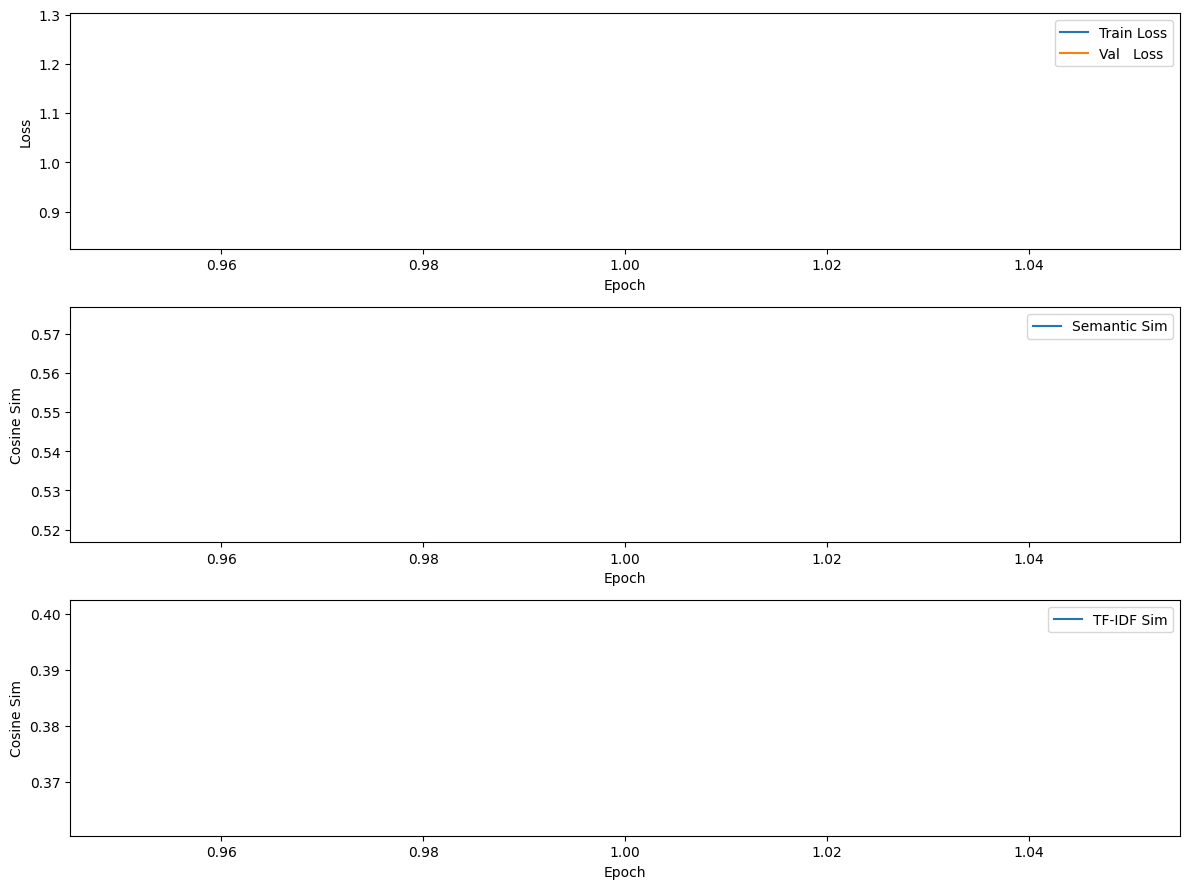

Eval:  92%|█████████▏| 55/60 [00:15<00:01,  3.79it/s]WARNING:root:Missing path 



--- Test Evaluation ---
Test Loss   : 0.8280

--- 10 Random Examples from Test Set ---

Example 66
Raw Report:     [FINDING       ]_x000D_Diffuse osteopenia. 
Right lateral malleolar bursa, soft tissue swelling. 
Both calcaneus, enthesophytes_x000D__x000D_[CONCLUSION    ]_x000D_Diffuse osteopenia. 
Right lateral malleolar bursa, soft tissue swelling. 
Both calcaneus, enthesophytes_x000D__x000D_[RECOMMENDATION]_x000D_-
Cleaned Report: Diffuse osteopenia. Right lateral malleolar bursa, soft tissue swelling. Both calcaneus, enthesophytes <|endoftext|>
Generated:      Diffuse osteopenia degenerative change 

Example 133
Raw Report:     [ Finding ]_x000D_
_x000D_
[ Diagnosis ]_x000D_
Tiny osteophyte of right 1st MTP joint._x000D_
Subtle radiolucent lesion of rigth 1st proximal phalangeal bone base._x000D_
 --- suspicious subchondral cyst._x000D_
Accessory navicular bone, both._x000D_
[ Recommend ]_x000D_

Cleaned Report: Tiny osteophyte of right 1st MTP joint. Subtle radiolucent lesion of 

In [2]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# 0) Utility functions
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra','oa','gout']
    normal   = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal':   data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal':   class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced, final_counts = [], {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes)==2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    if is_binary and len(target_classes)!=2:
        raise ValueError("Binary classification requires exactly 2 target classes.")
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
        logging.info("Applied augmentation: dataset doubled")
    return balanced, class_counts, final_counts

# =============================================================================
# 1) Transforms
# =============================================================================
imagenet_mean = [0.485,0.456,0.406]
imagenet_std  = [0.229,0.224,0.225]

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112,112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# 2) Dataset
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        # target classes
        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")
        if not isinstance(self.target_classes, list):
            raise TypeError(f"target_classes must be list, got {type(self.target_classes)}")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra':'abnormal','oa':'abnormal','gout':'abnormal','normal':'normal'}
            if self.abnormal_classify else None
        )

        # load and filter JSON
        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path','')
            fp = item.get('file_paths', [])
            # coerce file_paths to list
            if isinstance(fp, str):
                fp = [fp]
            elif not isinstance(fp, list):
                fp = []
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))
            else:
                logging.warning(f"Skipping entry; no valid files in {paths}")

        # build data dict
        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class','unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path':            merged,
                'left_right_file_path': fp,
                'class_label':          cls,
                'diagnosis':            item.get('diagnosis',''),
                'keypoints':            item.get('keypoints',{})
            }

        # binary balancing if needed
        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.eos_token = None  # set after tokenizer init

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt,0) if pt else torch.zeros(34,3,112,112)

        raw = e.get('diagnosis','')
        clean = self._clean_report(raw)
        tok = tokenizer(clean, truncation=True, max_length=512, return_tensors='pt')

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x,y,s = int(pts[3*i]),int(pts[3*i+1]),pts[3*i+2]
                if s>0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        try:
                            lst.append(cv2.resize(c, patch_size))
                        except Exception as ex:
                            logging.warning(f"Failed to resize patch: {ex}")
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1],patch_size[0],3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if os.path.exists(pth):
                img_arr = cv2.imread(pth)
                if img_arr is None:
                    logging.warning(f"cv2 failed to read {pth}")
                else:
                    arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                    if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
                    if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
            else:
                logging.warning(f"Missing path {pth}")
        else:
            for side, pth in zip(['left','right'], paths):
                if not os.path.exists(pth):
                    logging.warning(f"Missing path {pth}")
                    continue
                img_arr = cv2.imread(pth)
                if img_arr is None:
                    logging.warning(f"cv2 failed to read {pth}")
                    continue
                arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                if kps_dict.get(side):
                    lst = extract(arr, kps_dict[side])
                    if side == 'left':
                        left = lst
                    else:
                        right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return [np.zeros((patch_size[1],patch_size[0],3),np.uint8)] * 34

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'[^\x00-\x7F]+',' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        if text and not text.endswith(self.eos_token):
            text += ' ' + self.eos_token
        return text

# =============================================================================
# 3) Collate
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts  = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p-p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids   = [b['input_ids']      for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids,   batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs':      imgs,
        'patches':        patches,
        'input_ids':      ids,
        'attention_mask': masks,
        'raw_reports':    [b['raw_report']     for b in batch],
        'cleaned_reports':[b['cleaned_report'] for b in batch]
    }

# =============================================================================
# 4) Model
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        # global vision encoder
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)
        # patch vision encoder
        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)
        # cross-modal attention
        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)
        # GPT‑2 decoder with cross‑attention
        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)
        B, N, C, H, W = patches.shape
        p = patches.view(B*N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder,'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf)
        pf = pf.view(B, N, 768)
        cat = torch.cat([g, pf], dim=1)
        comb, _ = self.attn(cat, cat, cat)
        comb = self.norm(comb)
        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )

# =============================================================================
# 5) Train / Eval helpers
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Train", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []

    for b in tqdm(loader, desc="Eval", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            prompt = ids[:, :1]
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)

            B, N, C, H, W = pts.shape
            p = pts.view(B*N, C, H, W)
            pf = (model.patch_encoder.forward_features(p)
                  if hasattr(model.patch_encoder,'forward_features')
                  else model.patch_encoder(p))
            pf = model._pool(pf)
            pf = model.patch_proj(pf)
            pf = pf.view(B, N, 768)

            cat = torch.cat([g, pf], dim=1)
            comb, _ = model.attn(cat, cat, cat)
            comb = model.norm(comb)

            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=comb,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                early_stopping=True,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt  = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def compute_tfidf_similarity(gen, gt):
    vec = TfidfVectorizer().fit(gen + gt)
    tgm = vec.transform(gen)
    gtm = vec.transform(gt)
    sims = [cosine_similarity(tgm[i], gtm[i])[0][0] for i in range(len(gen))]
    return np.mean(sims)

def plot_metrics(train_losses, val_losses, sems, tfids):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,9))
    plt.subplot(3,1,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val   Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(3,1,2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Cosine Sim"); plt.legend()
    plt.subplot(3,1,3)
    plt.plot(epochs, tfids, label="TF-IDF Sim")
    plt.xlabel("Epoch"); plt.ylabel("Cosine Sim"); plt.legend()
    plt.tight_layout()
    plt.show()

# =============================================================================
# 6) Main
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_fixed.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['ra','oa','gout','normal','uncertain','ref.prev']
cfg.DATASET.BALANCE        = False
cfg.DATASET.AUGMENT        = False

# tokenizer & device
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# dataset
dataset = FinalSamplesDataset(cfg)
dataset.eos_token = tokenizer.eos_token

# overall class distribution
dist = Counter(e['class_label'] for e in dataset.data.values())
print("Overall class distribution:")
for cls, cnt in dist.items():
    print(f"  {cls}: {cnt}")

# split
n = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

print(f"Number of training samples:   {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")
print(f"Number of test samples:       {len(test_ds)}")

# loaders
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

# model & optim
model     = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.cuda.amp.GradScaler()

# train
num_epochs = 1
train_losses, val_losses, sems, tfids = [], [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    t_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    v_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem  = compute_semantic_similarity(gen_txt, gt_txt)
    tfid = compute_tfidf_similarity(gen_txt, gt_txt)
    train_losses.append(t_loss)
    val_losses.append(v_loss)
    sems.append(sem)
    tfids.append(tfid)
    print(f"  Train Loss : {t_loss:.4f}")
    print(f"  Val   Loss : {v_loss:.4f}")
    print(f"  Sem Sim    : {sem:.4f}")
    print(f"  TF-IDF Sim : {tfid:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems, tfids)

# final test
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
print("\n--- Test Evaluation ---")
print(f"Test Loss   : {test_loss:.4f}")

print("\n--- 10 Random Examples from Test Set ---")
for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
    ex = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)
    prompt= ex['input_ids'][:1].unsqueeze(0).to(device)

    # recompute encoder
    g = model.global_encoder(fi); g = model.global_proj(g).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B*N, C, H, W)
    pf = (model.patch_encoder.forward_features(p)
          if hasattr(model.patch_encoder,'forward_features')
          else model.patch_encoder(p))
    pf = model._pool(pf); pf = model.patch_proj(pf); pf = pf.view(B, N, 768)
    cat, _ = model.attn(torch.cat([g, pf], dim=1), torch.cat([g, pf], dim=1), torch.cat([g, pf], dim=1))
    comb = model.norm(cat)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        attention_mask=torch.ones_like(prompt),
        max_length=120,
        early_stopping=True,
        do_sample=True,
        top_k=40,
        top_p=0.95,
        temperature=0.5,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\nExample {idx}")
    print("Raw Report:    ", raw)
    print("Cleaned Report:", clean)
    print("Generated:     ", gen)


Using device: cuda
Overall class distribution:
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60
Number of training samples:   1915
Number of validation samples: 239
Number of test samples:       240
Total samples:                2394


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten


Epoch 1/5


Train:   0%|          | 0/479 [00:00<?, ?it/s]/tmp/ipykernel_13260/2952873513.py:383: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss : 1.3044
  Val   Loss : 0.8829
  Sem Sim    : 0.5608
  TF-IDF Sim : 0.3839

Epoch 2/5


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss : 0.7878
  Val   Loss : 0.7863
  Sem Sim    : 0.5844
  TF-IDF Sim : 0.4145

Epoch 3/5


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss : 0.6814
  Val   Loss : 0.7441
  Sem Sim    : 0.5971
  TF-IDF Sim : 0.4469

Epoch 4/5


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss : 0.6041
  Val   Loss : 0.7204
  Sem Sim    : 0.6358
  TF-IDF Sim : 0.4510

Epoch 5/5


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss : 0.5540
  Val   Loss : 0.7203
  Sem Sim    : 0.6436
  TF-IDF Sim : 0.4627


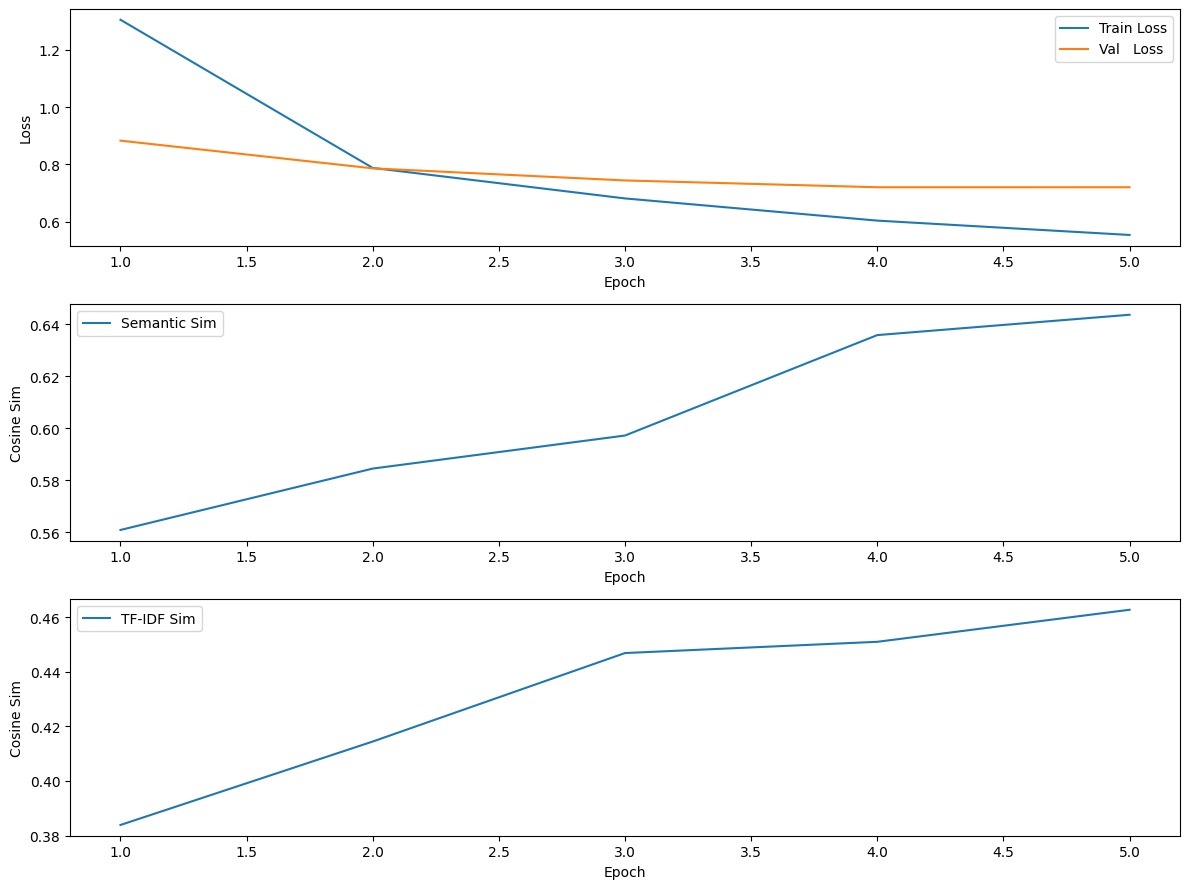

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


--- Test Evaluation ---
Test Loss               : 0.6497
Test Semantic Similarity: 0.6457

--- 10 Random Examples from Test Set ---

Example 170
Raw Report:     [ Finding ]_x000D_
no bony lesion._x000D_
[ Conclusion ]_x000D_
no bony lesion._x000D_
[ Recommend ]_x000D_

Cleaned Report: no bony lesion. <|endoftext|>
Generated:      no significant bony lesion on radiographs. 

Example 99
Raw Report:     [ Finding ]_x000D_
no significant bony lesion on radiographs._x000D_
_x000D_
[ Conclusion ]_x000D_
no significant bony lesion on radiographs._x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report: no significant bony lesion on radiographs. <|endoftext|>
Generated:      no bony lesion. 

Example 218
Raw Report:     [ Finding ]_x000D_
degenerative change_x000D_
[ Conclusion ]_x000D_
degenerative change_x000D_
[ Recommend ]_x000D_

Cleaned Report: degenerative change <|endoftext|>
Generated:      degenerative change 

Example 97
Raw Report:     [ Finding ]_x000D_
pes planus, both._x000D_
both 

In [2]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# 0) Utility functions
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra','oa','gout']
    normal   = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal':   data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal':   class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced, final_counts = [], {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes)==2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    if is_binary and len(target_classes)!=2:
        raise ValueError("Binary classification requires exactly 2 target classes.")
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
        logging.info("Applied augmentation: dataset doubled")
    return balanced, class_counts, final_counts

# =============================================================================
# 1) Transforms
# =============================================================================
imagenet_mean = [0.485,0.456,0.406]
imagenet_std  = [0.229,0.224,0.225]

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112,112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# 2) Dataset
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        # target classes
        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")
        if not isinstance(self.target_classes, list):
            raise TypeError(f"target_classes must be list, got {type(self.target_classes)}")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra':'abnormal','oa':'abnormal','gout':'abnormal','normal':'normal'}
            if self.abnormal_classify else None
        )

        # load and filter JSON
        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path','')
            fp = item.get('file_paths', [])
            # coerce file_paths to list
            if isinstance(fp, str):
                fp = [fp]
            elif not isinstance(fp, list):
                fp = []
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))
            else:
                logging.warning(f"Skipping entry; no valid files in {paths}")

        # build data dict
        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class','unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path':            merged,
                'left_right_file_path': fp,
                'class_label':          cls,
                'diagnosis':            item.get('diagnosis',''),
                'keypoints':            item.get('keypoints',{})
            }

        # binary balancing if needed
        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.eos_token = None  # set after tokenizer init

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt,0) if pt else torch.zeros(34,3,112,112)

        raw = e.get('diagnosis','')
        clean = self._clean_report(raw)
        tok = tokenizer(clean, truncation=True, max_length=512, return_tensors='pt')

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x,y,s = int(pts[3*i]),int(pts[3*i+1]),pts[3*i+2]
                if s>0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        try:
                            lst.append(cv2.resize(c, patch_size))
                        except Exception as ex:
                            logging.warning(f"Failed to resize patch: {ex}")
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1],patch_size[0],3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        # single merged image
        if len(paths) == 1:
            pth = paths[0]
            if not pth:
                # skip empty path silently
                return pad17([]) + pad17([])
            if not os.path.exists(pth):
                logging.warning(f"Missing path: {pth}")
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                logging.warning(f"cv2 failed to read {pth}")
            else:
                arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
                if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            # separate left/right images
            for side, pth in zip(['left','right'], paths):
                if not pth:
                    continue  # skip empty entries without warning
                if not os.path.exists(pth):
                    logging.warning(f"Missing path: {pth}")
                    continue
                img_arr = cv2.imread(pth)
                if img_arr is None:
                    logging.warning(f"cv2 failed to read {pth}")
                    continue
                arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                if kps_dict.get(side):
                    lst = extract(arr, kps_dict[side])
                    if side == 'left':
                        left = lst
                    else:
                        right = lst

        # mirror if needed
        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        # normalize unicode
        text = unicodedata.normalize('NFKC', text or '')
        # remove lines of dashes
        text = re.sub(r'(?m)^-+\s*$', '', text)
        # remove non-ASCII
        text = re.sub(r'[^\x00-\x7F]+',' ', text)
        # collapse repeated punctuation
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        # standardize section tags
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        # remove recommendations and beyond
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        # de-duplicate FINDING vs CONCLUSION
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        # strip section tags
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        # remove stray markers
        text = text.replace('_x000D_', ' ')
        # collapse whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        # append EOS token if missing
        if text and not text.endswith(self.eos_token):
            text += ' ' + self.eos_token
        return text

# =============================================================================
# 3) Collate
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts  = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p-p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids   = [b['input_ids']      for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids,   batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs':      imgs,
        'patches':        patches,
        'input_ids':      ids,
        'attention_mask': masks,
        'raw_reports':    [b['raw_report']     for b in batch],
        'cleaned_reports':[b['cleaned_report'] for b in batch]
    }

# =============================================================================
# 4) Model
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        # global vision encoder
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)
        # patch vision encoder
        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)
        # cross-modal attention
        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)
        # GPT‑2 decoder with cross‑attention
        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)
        B, N, C, H, W = patches.shape
        p = patches.view(B*N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder,'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf)
        pf = pf.view(B, N, 768)
        cat = torch.cat([g, pf], dim=1)
        comb, _ = self.attn(cat, cat, cat)
        comb = self.norm(comb)
        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )

# =============================================================================
# 5) Train / Eval helpers
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Train", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []

    for b in tqdm(loader, desc="Eval", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            prompt = ids[:, :1]
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)

            B, N, C, H, W = pts.shape
            p = pts.view(B*N, C, H, W)
            pf = (model.patch_encoder.forward_features(p)
                  if hasattr(model.patch_encoder,'forward_features')
                  else model.patch_encoder(p))
            pf = model._pool(pf)
            pf = model.patch_proj(pf)
            pf = pf.view(B, N, 768)

            cat = torch.cat([g, pf], dim=1)
            comb, _ = model.attn(cat, cat, cat)
            comb = model.norm(comb)

            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=comb,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                early_stopping=True,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt  = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def compute_tfidf_similarity(gen, gt):
    vec = TfidfVectorizer().fit(gen + gt)
    tgm = vec.transform(gen)
    gtm = vec.transform(gt)
    sims = [cosine_similarity(tgm[i], gtm[i])[0][0] for i in range(len(gen))]
    return np.mean(sims)

def plot_metrics(train_losses, val_losses, sems, tfids):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,9))
    plt.subplot(3,1,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val   Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(3,1,2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Cosine Sim"); plt.legend()
    plt.subplot(3,1,3)
    plt.plot(epochs, tfids, label="TF-IDF Sim")
    plt.xlabel("Epoch"); plt.ylabel("Cosine Sim"); plt.legend()
    plt.tight_layout()
    plt.show()

# =============================================================================
# 6) Main
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_fixed.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['ra','oa','gout','normal','uncertain','ref.prev']
cfg.DATASET.BALANCE        = False
cfg.DATASET.AUGMENT        = False

# tokenizer & device
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# dataset
dataset = FinalSamplesDataset(cfg)
dataset.eos_token = tokenizer.eos_token

# overall class distribution
dist = Counter(e['class_label'] for e in dataset.data.values())
print("Overall class distribution:")
for cls, cnt in dist.items():
    print(f"  {cls}: {cnt}")

# split
n = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

print(f"Number of training samples:   {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")
print(f"Number of test samples:       {len(test_ds)}")
print(f"Total samples:                {n}")

# loaders
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

# model & optim
model     = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.cuda.amp.GradScaler()

# train
num_epochs = 5
train_losses, val_losses, sems, tfids = [], [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    t_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    v_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem  = compute_semantic_similarity(gen_txt, gt_txt)
    tfid = compute_tfidf_similarity(gen_txt, gt_txt)
    train_losses.append(t_loss)
    val_losses.append(v_loss)
    sems.append(sem)
    tfids.append(tfid)
    print(f"  Train Loss : {t_loss:.4f}")
    print(f"  Val   Loss : {v_loss:.4f}")
    print(f"  Sem Sim    : {sem:.4f}")
    print(f"  TF-IDF Sim : {tfid:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems, tfids)

# final test
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)
print("\n--- Test Evaluation ---")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

print("\n--- 10 Random Examples from Test Set ---")
for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
    ex = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)
    prompt= ex['input_ids'][:1].unsqueeze(0).to(device)

    # recompute encoder
    g = model.global_encoder(fi); g = model.global_proj(g).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B*N, C, H, W)
    pf = (model.patch_encoder.forward_features(p)
          if hasattr(model.patch_encoder,'forward_features')
          else model.patch_encoder(p))
    pf = model._pool(pf); pf = model.patch_proj(pf); pf = pf.view(B, N, 768)
    cat, _ = model.attn(torch.cat([g, pf], dim=1), torch.cat([g, pf], dim=1), torch.cat([g, pf], dim=1))
    comb = model.norm(cat)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        attention_mask=torch.ones_like(prompt),
        max_length=120,
        early_stopping=True,
        do_sample=True,
        top_k=40,
        top_p=0.95,
        temperature=0.5,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\nExample {idx}")
    print("Raw Report:    ", raw)
    print("Cleaned Report:", clean)
    print("Generated:     ", gen)


2025-05-05 11:04:42.458810: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 11:04:42.465424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746468282.473000   17917 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746468282.475316   17917 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746468282.481302   17917 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using device: cuda

Dataset class distribution:
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten


Epoch 1/10


Training:   0%|          | 0/479 [00:00<?, ?it/s]/tmp/ipykernel_17917/3398206600.py:345: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.2982
  Validation Loss     : 0.8115
  Semantic Similarity : 0.5549

Epoch 2/10


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.7902
  Validation Loss     : 0.7130
  Semantic Similarity : 0.5953

Epoch 3/10


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.6826
  Validation Loss     : 0.6781
  Semantic Similarity : 0.5979

Epoch 4/10


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.5907
  Validation Loss     : 0.6625
  Semantic Similarity : 0.6438

Epoch 5/10


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.5427
  Validation Loss     : 0.6684
  Semantic Similarity : 0.6221

Epoch 6/10


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.4892
  Validation Loss     : 0.6537
  Semantic Similarity : 0.6295

Epoch 7/10


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.4447
  Validation Loss     : 0.6785
  Semantic Similarity : 0.6572

Epoch 8/10


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.4161
  Validation Loss     : 0.6772
  Semantic Similarity : 0.6280

Epoch 9/10


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.3910
  Validation Loss     : 0.6885
  Semantic Similarity : 0.6570

Epoch 10/10


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.3702
  Validation Loss     : 0.6919
  Semantic Similarity : 0.6613


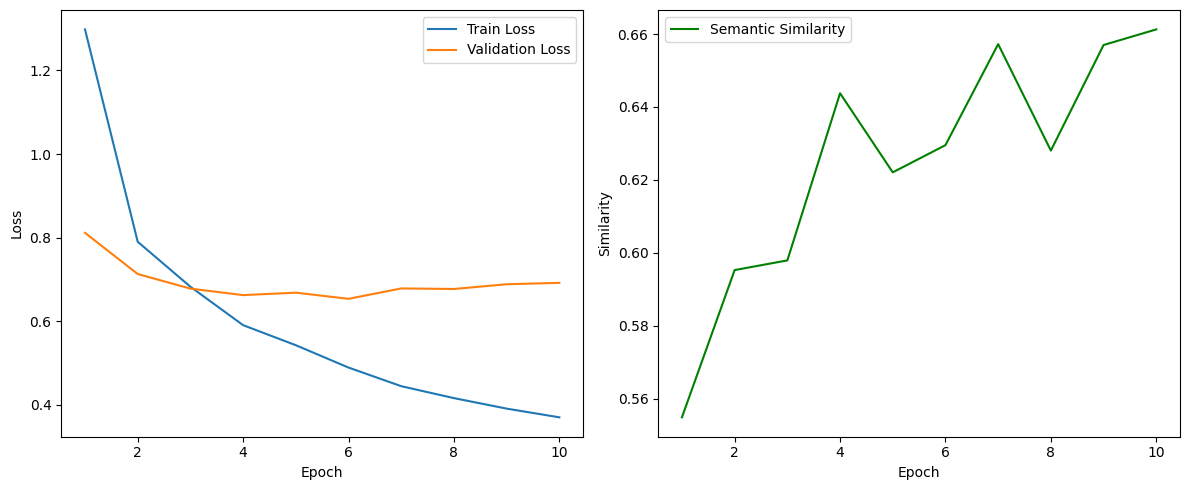

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss              : 0.7503
Test Semantic Sim     : 0.6415

===== RANDOM TEST EXAMPLES =====

--- Example 19 ---
Raw Report       : 
[ Finding ]_x000D_
degenerative change._x000D_
[ Conclusion ]_x000D_
degenerative change._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
degenerative change. <|endoftext|>
Generated Report : 
degenerative change. 

--- Example 11 ---
Raw Report       : 
[ Finding ]_x000D_
Lt. ankle soft tissue swelling._x000D_
degenerative change of both hip joints._x000D_
both 1st MTP joint, gout arthritis._x000D_
both wrist, R/O gout arthritis._x000D_
_x000D_
_x000D_
[ Conclusion ]_x000D_
Lt. ankle soft tissue swelling._x000D_
degenerative change of both hip joints._x000D_
both 1st MTP joint, gout arthritis._x000D_
both wrist, R/O gout arthritis._x000D_
_x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
Lt. ankle soft tissue swelling. degenerative change of both hip joints. both 1st MTP joint, gout arthritis. both wrist, 

In [1]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)
        tok = tokenizer(clean, truncation=True, max_length=512, return_tensors='pt')

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'): left = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left', 'right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side == 'left': left = lst
                            else: right = lst

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE | re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        if text and not text.endswith(self.eos_token):
            text += ' ' + self.eos_token
        return text

# =============================================================================
# Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs': imgs,
        'patches': patches,
        'input_ids': ids,
        'attention_mask': masks,
        'raw_reports': [b['raw_report'] for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2, 3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)

        B, N, C, H, W = patches.shape
        p = patches.view(B * N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf)
        pf = pf.view(B, N, 768)

        cat = torch.cat([g, pf], dim=1)
        comb, _ = self.attn(cat, cat, cat)
        comb = self.norm(comb)

        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )

# =============================================================================
# Train / Eval helpers
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []

    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            prompt = ids[:, :1]
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)

            B, N, C, H, W = pts.shape
            p = pts.view(B * N, C, H, W)
            pf = model.patch_encoder(p)
            pf = model._pool(pf)
            pf = model.patch_proj(pf)
            pf = pf.view(B, N, 768)

            cat = torch.cat([g, pf], dim=1)
            comb, _ = model.attn(cat, cat, cat)
            comb = model.norm(comb)

            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=comb,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )

            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, sems, label="Semantic Similarity", color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================

class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON = 'final_samples_both_only_fixed.json'
cfg.DATASET.USE_RAW = True
cfg.DATASET.USE_PATCH = True
cfg.DATASET.REPORT = True
cfg.DATASET.TARGET_CLASSES = ['ra', 'oa', 'gout', 'normal', 'uncertain', 'ref.prev']
cfg.DATASET.BALANCE = False
cfg.DATASET.AUGMENT = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

dataset = FinalSamplesDataset(cfg)
dataset.eos_token = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
print("\nDataset class distribution:")
for cls, cnt in dist.items():
    print(f"  {cls}: {cnt}")

n = len(dataset)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

model = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 10
train_losses, val_losses, sems = [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss              : {test_loss:.4f}")
print(f"Test Semantic Sim     : {test_sem:.4f}")

print("\n===== RANDOM TEST EXAMPLES =====")
for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
    ex = test_ds[idx]
    raw = ex['raw_report']
    clean = ex['cleaned_report']
    fi = ex['full_img'].unsqueeze(0).to(device)
    pa = ex['patches'].unsqueeze(0).to(device)
    prompt = ex['input_ids'][:1].unsqueeze(0).to(device)

    g = model.global_encoder(fi)
    g = model.global_proj(g).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B * N, C, H, W)
    pf = model.patch_encoder(p)
    pf = model._pool(pf)
    pf = model.patch_proj(pf)
    pf = pf.view(B, N, 768)

    cat = torch.cat([g, pf], dim=1)
    comb, _ = model.attn(cat, cat, cat)
    comb = model.norm(comb)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        attention_mask=torch.ones_like(prompt),
        max_length=120,
        do_sample=True,
        top_k=40,
        top_p=0.95,
        temperature=0.5,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )

    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


Using device: cuda

Dataset class distribution:
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten


Epoch 1/20


Training:   0%|          | 0/479 [00:00<?, ?it/s]/tmp/ipykernel_17917/4173565160.py:345: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.3099
  Validation Loss     : 0.8398
  Semantic Similarity : 0.5333

Epoch 2/20


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.7979
  Validation Loss     : 0.7528
  Semantic Similarity : 0.5592

Epoch 3/20


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.6829
  Validation Loss     : 0.7070
  Semantic Similarity : 0.6090

Epoch 4/20


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.6009
  Validation Loss     : 0.6887
  Semantic Similarity : 0.6158

Epoch 5/20


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.5281
  Validation Loss     : 0.6803
  Semantic Similarity : 0.6168

Epoch 6/20


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.4907
  Validation Loss     : 0.6752
  Semantic Similarity : 0.6447

Epoch 7/20


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.4400
  Validation Loss     : 0.6865
  Semantic Similarity : 0.6406

Epoch 8/20


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.4026
  Validation Loss     : 0.6927
  Semantic Similarity : 0.6412

Epoch 9/20


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.3819
  Validation Loss     : 0.6994
  Semantic Similarity : 0.6527

Epoch 10/20


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.3693
  Validation Loss     : 0.7099
  Semantic Similarity : 0.6518

Epoch 11/20


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.4561
  Validation Loss     : 0.7010
  Semantic Similarity : 0.6219

Epoch 12/20


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.4081
  Validation Loss     : 0.7238
  Semantic Similarity : 0.6345

Epoch 13/20


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.3776
  Validation Loss     : 0.7444
  Semantic Similarity : 0.6295

Epoch 14/20


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.3432
  Validation Loss     : 0.7277
  Semantic Similarity : 0.6257

Epoch 15/20


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.3090
  Validation Loss     : 0.7890
  Semantic Similarity : 0.6418

Epoch 16/20


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.2880
  Validation Loss     : 0.8108
  Semantic Similarity : 0.6548

Epoch 17/20


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.2639
  Validation Loss     : 0.8095
  Semantic Similarity : 0.6505

Epoch 18/20


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.2399
  Validation Loss     : 0.8446
  Semantic Similarity : 0.6342

Epoch 19/20


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.2164
  Validation Loss     : 0.8873
  Semantic Similarity : 0.6590

Epoch 20/20


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.2030
  Validation Loss     : 0.9287
  Semantic Similarity : 0.6499


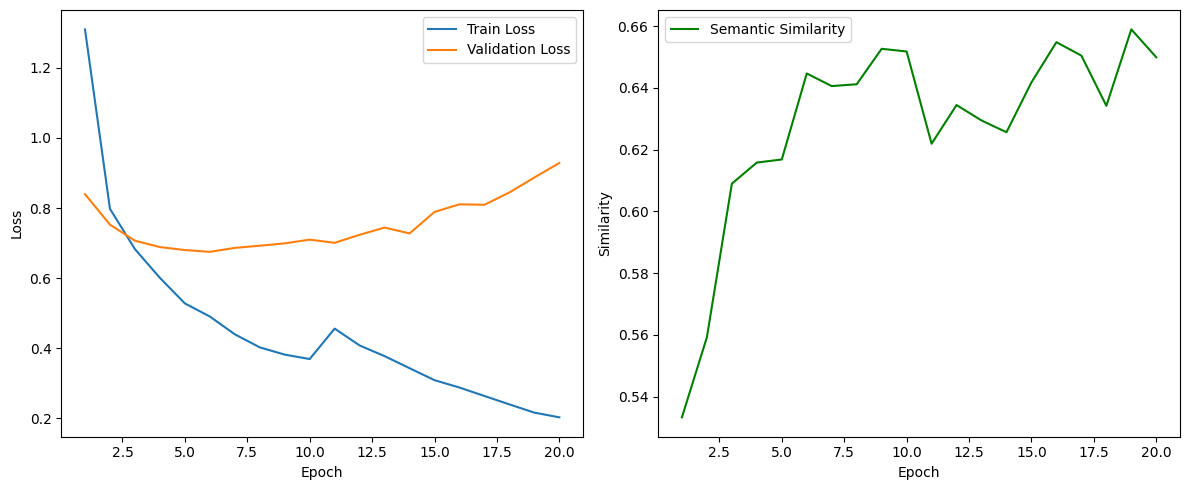

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss              : 1.0544
Test Semantic Sim     : 0.6139

===== RANDOM TEST EXAMPLES =====

--- Example 20 ---
Raw Report       : 
[ Finding ]_x000D_
both hallux valgus._x000D_
_x000D_
degenerative change of both feet, hands and knee_x000D_
_x000D_
[ Conclusion ]_x000D_
both hallux valgus._x000D_
_x000D_
degenerative change of both feet, hands and knee_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
both hallux valgus. degenerative change of both feet, hands and knee both hallux valgus. degenerative change of both feet, hands and knee <|endoftext|>
Generated Report : 
both ankle OA. 

--- Example 97 ---
Raw Report       : 
[ Finding ]_x000D_
_x000D_
[ Conclusion ]_x000D_
tophi, around right 1st MTP joint_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
tophi, around right 1st MTP joint <|endoftext|>
Generated Report : 
tiny suspicious calcification adjacent left cuboid bone. 

--- Example 7 ---
Raw Report       : 
[ Finding ]_x000D_
both 1st M

In [2]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)
        tok = tokenizer(clean, truncation=True, max_length=512, return_tensors='pt')

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'): left = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left', 'right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side == 'left': left = lst
                            else: right = lst

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE | re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        if text and not text.endswith(self.eos_token):
            text += ' ' + self.eos_token
        return text

# =============================================================================
# Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs': imgs,
        'patches': patches,
        'input_ids': ids,
        'attention_mask': masks,
        'raw_reports': [b['raw_report'] for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2, 3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)

        B, N, C, H, W = patches.shape
        p = patches.view(B * N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf)
        pf = pf.view(B, N, 768)

        cat = torch.cat([g, pf], dim=1)
        comb, _ = self.attn(cat, cat, cat)
        comb = self.norm(comb)

        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )

# =============================================================================
# Train / Eval helpers
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []

    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            prompt = ids[:, :1]
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)

            B, N, C, H, W = pts.shape
            p = pts.view(B * N, C, H, W)
            pf = model.patch_encoder(p)
            pf = model._pool(pf)
            pf = model.patch_proj(pf)
            pf = pf.view(B, N, 768)

            cat = torch.cat([g, pf], dim=1)
            comb, _ = model.attn(cat, cat, cat)
            comb = model.norm(comb)

            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=comb,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )

            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, sems, label="Semantic Similarity", color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================

class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON = 'final_samples_both_only_fixed.json'
cfg.DATASET.USE_RAW = True
cfg.DATASET.USE_PATCH = True
cfg.DATASET.REPORT = True
cfg.DATASET.TARGET_CLASSES = ['ra', 'oa', 'gout', 'normal', 'uncertain', 'ref.prev']
cfg.DATASET.BALANCE = False
cfg.DATASET.AUGMENT = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

dataset = FinalSamplesDataset(cfg)
dataset.eos_token = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
print("\nDataset class distribution:")
for cls, cnt in dist.items():
    print(f"  {cls}: {cnt}")

n = len(dataset)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

model = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 20
train_losses, val_losses, sems = [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss              : {test_loss:.4f}")
print(f"Test Semantic Sim     : {test_sem:.4f}")

print("\n===== RANDOM TEST EXAMPLES =====")
for idx in random.sample(range(len(test_ds)), min(20, len(test_ds))):
    ex = test_ds[idx]
    raw = ex['raw_report']
    clean = ex['cleaned_report']
    fi = ex['full_img'].unsqueeze(0).to(device)
    pa = ex['patches'].unsqueeze(0).to(device)
    prompt = ex['input_ids'][:1].unsqueeze(0).to(device)

    g = model.global_encoder(fi)
    g = model.global_proj(g).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B * N, C, H, W)
    pf = model.patch_encoder(p)
    pf = model._pool(pf)
    pf = model.patch_proj(pf)
    pf = pf.view(B, N, 768)

    cat = torch.cat([g, pf], dim=1)
    comb, _ = model.attn(cat, cat, cat)
    comb = model.norm(comb)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        attention_mask=torch.ones_like(prompt),
        max_length=120,
        do_sample=True,
        top_k=40,
        top_p=0.95,
        temperature=0.5,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )

    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


## Updated JSON File

Using device: cuda

Dataset class distribution:
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten


Epoch 1/1


Training:   0%|          | 0/479 [00:00<?, ?it/s]/tmp/ipykernel_27097/3403723794.py:345: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.2999
  Validation Loss     : 0.8299
  Semantic Similarity : 0.5556


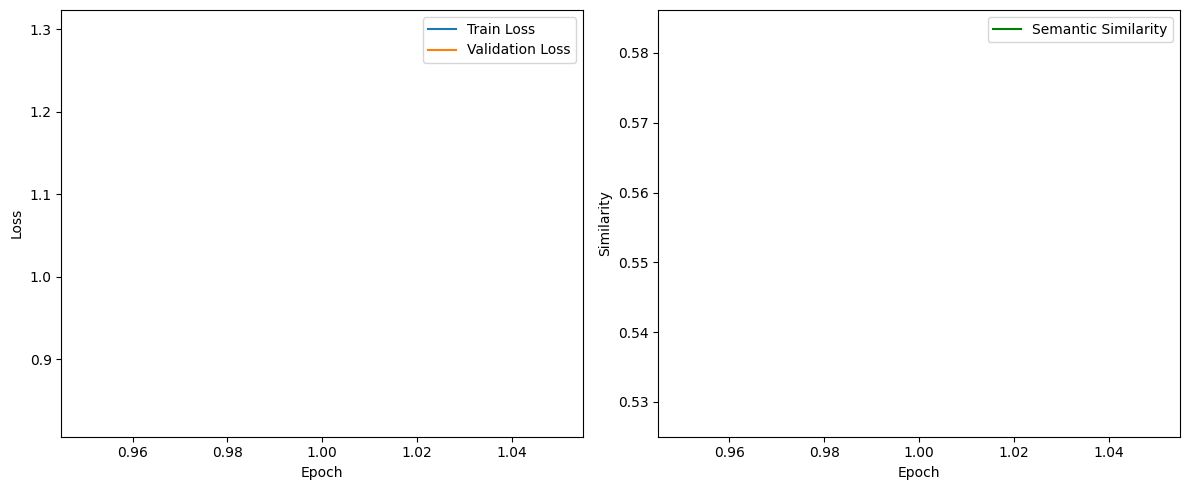

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss              : 0.8096
Test Semantic Sim     : 0.5502

===== RANDOM TEST EXAMPLES =====

--- Example 231 ---
Raw Report       : 
[ Finding ]_x000D_
both 1st toe, brachydactyly._x000D_
degenerative change._x000D_
[ Conclusion ]_x000D_
both 1st toe, brachydactyly._x000D_
degenerative change._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
both 1st toe, brachydactyly. degenerative change. <|endoftext|>
Generated Report : 
both 1st MTP joint, OA. 

--- Example 203 ---
Raw Report       : 
[ Finding ]_x000D_
no significant interval change since last study._x000D_
[ Conclusion ]_x000D_
no significant interval change since last study._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
no significant interval change since last study. <|endoftext|>
Generated Report : 
no bony lesion. 

--- Example 11 ---
Raw Report       : 
[ Finding ]_x000D_
advanced RA._x000D_
s/p TKRA, both._x000D_
postop. state, left humerus._x000D_
degenerative change._x000D_
[ Co

In [2]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)
        tok = tokenizer(clean, truncation=True, max_length=512, return_tensors='pt')

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'): left = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left', 'right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side == 'left': left = lst
                            else: right = lst

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE | re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        if text and not text.endswith(self.eos_token):
            text += ' ' + self.eos_token
        return text

# =============================================================================
# Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs': imgs,
        'patches': patches,
        'input_ids': ids,
        'attention_mask': masks,
        'raw_reports': [b['raw_report'] for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2, 3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)

        B, N, C, H, W = patches.shape
        p = patches.view(B * N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf)
        pf = pf.view(B, N, 768)

        cat = torch.cat([g, pf], dim=1)
        comb, _ = self.attn(cat, cat, cat)
        comb = self.norm(comb)

        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )

# =============================================================================
# Train / Eval helpers
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []

    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            prompt = ids[:, :1]
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)

            B, N, C, H, W = pts.shape
            p = pts.view(B * N, C, H, W)
            pf = model.patch_encoder(p)
            pf = model._pool(pf)
            pf = model.patch_proj(pf)
            pf = pf.view(B, N, 768)

            cat = torch.cat([g, pf], dim=1)
            comb, _ = model.attn(cat, cat, cat)
            comb = model.norm(comb)

            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=comb,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )

            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, sems, label="Semantic Similarity", color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================

class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW = True
cfg.DATASET.USE_PATCH = True
cfg.DATASET.REPORT = True
cfg.DATASET.TARGET_CLASSES = ['ra', 'oa', 'gout', 'normal', 'uncertain', 'ref.prev']
cfg.DATASET.BALANCE = False
cfg.DATASET.AUGMENT = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

dataset = FinalSamplesDataset(cfg)
dataset.eos_token = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
print("\nDataset class distribution:")
for cls, cnt in dist.items():
    print(f"  {cls}: {cnt}")

n = len(dataset)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

model = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 1
train_losses, val_losses, sems = [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss              : {test_loss:.4f}")
print(f"Test Semantic Sim     : {test_sem:.4f}")

print("\n===== RANDOM TEST EXAMPLES =====")
for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
    ex = test_ds[idx]
    raw = ex['raw_report']
    clean = ex['cleaned_report']
    fi = ex['full_img'].unsqueeze(0).to(device)
    pa = ex['patches'].unsqueeze(0).to(device)
    prompt = ex['input_ids'][:1].unsqueeze(0).to(device)

    g = model.global_encoder(fi)
    g = model.global_proj(g).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B * N, C, H, W)
    pf = model.patch_encoder(p)
    pf = model._pool(pf)
    pf = model.patch_proj(pf)
    pf = pf.view(B, N, 768)

    cat = torch.cat([g, pf], dim=1)
    comb, _ = model.attn(cat, cat, cat)
    comb = model.norm(comb)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        attention_mask=torch.ones_like(prompt),
        max_length=120,
        do_sample=True,
        top_k=40,
        top_p=0.95,
        temperature=0.5,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )

    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


2025-05-06 09:32:09.364665: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 09:32:09.371420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746549129.379100   28104 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746549129.381447   28104 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746549129.387598   28104 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using device: cuda

Dataset class distribution:
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60

Number of training samples:   1915
Number of validation samples: 239
Number of test samples:       240
Total samples:                2394



INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten


Epoch 1/10


Training:   0%|          | 0/479 [00:00<?, ?it/s]/tmp/ipykernel_28104/628828703.py:347: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.3014
  Validation Loss     : 0.8631
  Semantic Similarity : 0.5809

Epoch 2/10


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.8115
  Validation Loss     : 0.7738
  Semantic Similarity : 0.6028

Epoch 3/10


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.6821
  Validation Loss     : 0.7508
  Semantic Similarity : 0.6135

Epoch 4/10


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.6023
  Validation Loss     : 0.7152
  Semantic Similarity : 0.6427

Epoch 5/10


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.5301
  Validation Loss     : 0.7079
  Semantic Similarity : 0.6411

Epoch 6/10


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.4890
  Validation Loss     : 0.7139
  Semantic Similarity : 0.6474

Epoch 7/10


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.4504
  Validation Loss     : 0.7402
  Semantic Similarity : 0.6547

Epoch 8/10


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.4102
  Validation Loss     : 0.7543
  Semantic Similarity : 0.6396

Epoch 9/10


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.3905
  Validation Loss     : 0.7537
  Semantic Similarity : 0.6407

Epoch 10/10


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.3739
  Validation Loss     : 0.7618
  Semantic Similarity : 0.6398


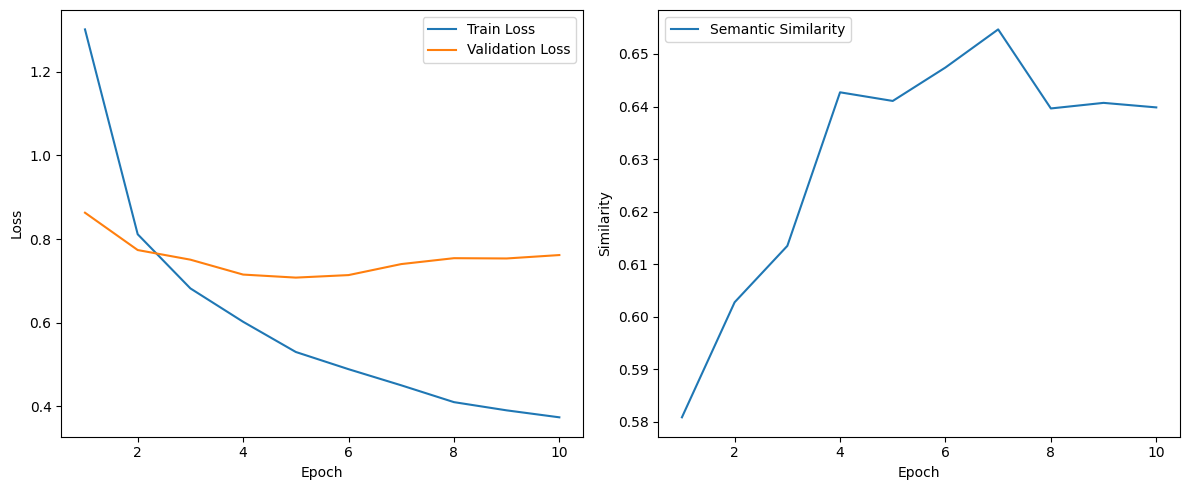

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss          : 0.7302
Test Semantic Sim  : 0.6602

===== RANDOM TEST EXAMPLES =====

--- Example 141 ---
Raw Report       : 
[ Finding ]_x000D_
old fracture with nonunion, right proximal phalanx._x000D_
probable gout, right big toe, left 2nd finger, left ankle._x000D_
[ Conclusion ]_x000D_
old fracture with nonunion, right proximal phalanx._x000D_
probable gout, right big toe, left 2nd finger, left ankle._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
old fracture with nonunion, right proximal phalanx. probable gout, right big toe, left 2nd finger, left ankle. <|endoftext|>
Generated Report : 
old osteophyte of right 1st MTP joint. 

--- Example 57 ---
Raw Report       : 
[ Finding ]_x000D_
degenerative change._x000D_
[ Conclusion ]_x000D_
degenerative change._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
degenerative change. <|endoftext|>
Generated Report : 
degenerative change. 

--- Example 25 ---
Raw Report       : 
[ Finding ]_x000D_


In [1]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)
        tok = tokenizer(clean, truncation=True, max_length=512, return_tensors='pt')

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'): left = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left', 'right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side == 'left': left = lst
                            else: right = lst

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE | re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        if text and not text.endswith(self.eos_token):
            text += ' ' + self.eos_token
        return text

# =============================================================================
# Collate function
# =============================================================================

def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs': imgs,
        'patches': patches,
        'input_ids': ids,
        'attention_mask': masks,
        'raw_reports': [b['raw_report'] for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model
# =============================================================================

class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2, 3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)

        B, N, C, H, W = patches.shape
        p = patches.view(B * N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf)
        pf = pf.view(B, N, 768)

        cat = torch.cat([g, pf], dim=1)
        comb, _ = self.attn(cat, cat, cat)
        comb = self.norm(comb)

        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )

# =============================================================================
# Train / Eval helpers
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []

    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            prompt = ids[:, :1]
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)

            B, N, C, H, W = pts.shape
            p = pts.view(B * N, C, H, W)
            pf = model.patch_encoder(p)
            pf = model._pool(pf)
            pf = model.patch_proj(pf)
            pf = pf.view(B, N, 768)

            cat = torch.cat([g, pf], dim=1)
            comb, _ = model.attn(cat, cat, cat)
            comb = model.norm(comb)

            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=comb,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )

            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, sems, label="Semantic Similarity")
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================

class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW = True
cfg.DATASET.USE_PATCH = True
cfg.DATASET.REPORT = True
cfg.DATASET.TARGET_CLASSES = ['ra', 'oa', 'gout', 'normal', 'uncertain', 'ref.prev']
cfg.DATASET.BALANCE = False
cfg.DATASET.AUGMENT = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

dataset = FinalSamplesDataset(cfg)
dataset.eos_token = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
print("\nDataset class distribution:")
for cls, cnt in dist.items():
    print(f"  {cls}: {cnt}")

# split into train / val / test
n = len(dataset)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

# print sample counts
print(f"\nNumber of training samples:   {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")
print(f"Number of test samples:       {len(test_ds)}")
print(f"Total samples:                {len(train_ds) + len(val_ds) + len(test_ds)}\n")

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

model = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 10
train_losses, val_losses, sems = [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss          : {test_loss:.4f}")
print(f"Test Semantic Sim  : {test_sem:.4f}")

print("\n===== RANDOM TEST EXAMPLES =====")
for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
    ex = test_ds[idx]
    raw = ex['raw_report']
    clean = ex['cleaned_report']
    fi = ex['full_img'].unsqueeze(0).to(device)
    pa = ex['patches'].unsqueeze(0).to(device)
    prompt = ex['input_ids'][:1].unsqueeze(0).to(device)

    g = model.global_encoder(fi)
    g = model.global_proj(g).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B * N, C, H, W)
    pf = model.patch_encoder(p)
    pf = model._pool(pf)
    pf = model.patch_proj(pf)
    pf = pf.view(B, N, 768)

    cat = torch.cat([g, pf], dim=1)
    comb, _ = model.attn(cat, cat, cat)
    comb = model.norm(comb)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        attention_mask=torch.ones_like(prompt),
        max_length=120,
        do_sample=True,
        top_k=40,
        top_p=0.95,
        temperature=0.5,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )

    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")
